# UCI-HAR

In [1]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=6280ab88655aea2ab4dba82af7970b3f122d831ea5502e42610656d68c95fd68
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=53dc239cfe1f3906d731082db5cd410af15b3135ac60bfd240567be12a14d29e
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


Device: cuda | pin_memory: True

Model params: 78,591

Epoch 05/100 | LR=0.0020 | Train Loss=0.1880 | TestF1=0.9301 | BestF1=0.9301 | Temp=4.982
Epoch 10/100 | LR=0.0020 | Train Loss=0.1557 | TestF1=0.9303 | BestF1=0.9376 | Temp=4.909
Epoch 15/100 | LR=0.0019 | Train Loss=0.1084 | TestF1=0.9470 | BestF1=0.9524 | Temp=4.782
Epoch 20/100 | LR=0.0018 | Train Loss=0.0860 | TestF1=0.9525 | BestF1=0.9616 | Temp=4.603
Epoch 25/100 | LR=0.0017 | Train Loss=0.0868 | TestF1=0.9568 | BestF1=0.9616 | Temp=4.378
Epoch 30/100 | LR=0.0016 | Train Loss=0.0766 | TestF1=0.9611 | BestF1=0.9641 | Temp=4.113
Epoch 35/100 | LR=0.0015 | Train Loss=0.0696 | TestF1=0.9512 | BestF1=0.9641 | Temp=3.813
Epoch 40/100 | LR=0.0013 | Train Loss=0.0708 | TestF1=0.9561 | BestF1=0.9641 | Temp=3.486
Epoch 45/100 | LR=0.0012 | Train Loss=0.0688 | TestF1=0.9605 | BestF1=0.9641 | Temp=3.141
Epoch 50/100 | LR=0.0010 | Train Loss=0.0678 | TestF1=0.9630 | BestF1=0.9641 | Temp=2.786
Epoch 55/100 | LR=0.0008 | Train Loss=0.0678 

padre_blocks.0.channel_mixing.2, padre_blocks.0.pre_hadamard_channel.1, padre_blocks.0.pre_hadamard_token.1, padre_blocks.0.token_mixing.2, padre_blocks.1.channel_mixing.2, padre_blocks.1.pre_hadamard_channel.1, padre_blocks.1.pre_hadamard_token.1, padre_blocks.1.token_mixing.2, padre_blocks.2.channel_mixing.2, padre_blocks.2.pre_hadamard_channel.1, padre_blocks.2.pre_hadamard_token.1, padre_blocks.2.token_mixing.2



Best Model Summary (selected by Best Test Macro-F1)
Accuracy          : 0.9647
Macro Precision   : 0.9648
Macro Recall      : 0.9650
Macro F1          : 0.9642
Params (M)        : 0.079
FLOPs (M)         : 7.138
CPU infer time(ms): 4.958 (batch=1)

Classification Report
                    precision    recall  f1-score   support

           Walking     1.0000    0.9415    0.9699       496
  Walking Upstairs     0.9848    0.9660    0.9753       471
Walking Downstairs     0.9052    1.0000    0.9502       420
           Sitting     0.9677    0.9165    0.9414       491
          Standing     0.9345    0.9662    0.9501       532
             Lying     0.9963    1.0000    0.9981       537

          accuracy                         0.9647      2947
         macro avg     0.9648    0.9650    0.9642      2947
      weighted avg     0.9662    0.9647    0.9648      2947



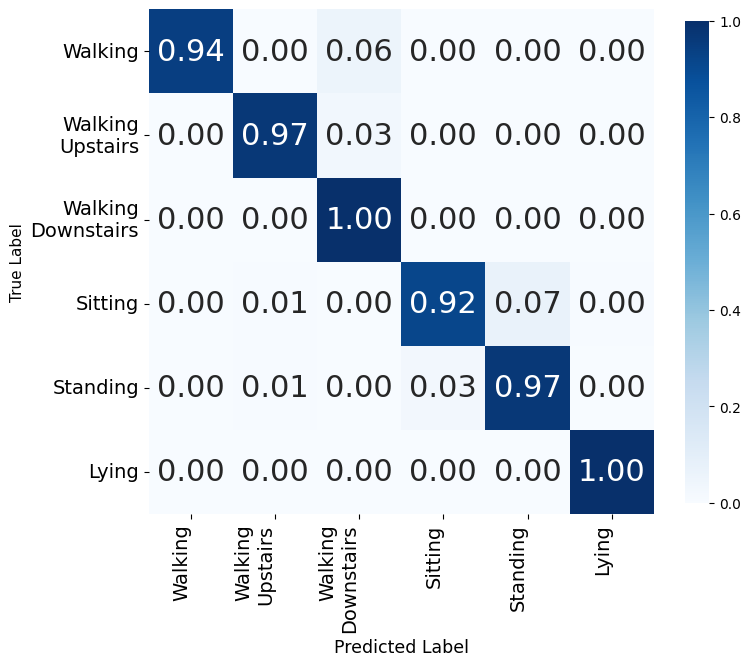


Running t-SNE on 2000 points (Perplexity=30)...


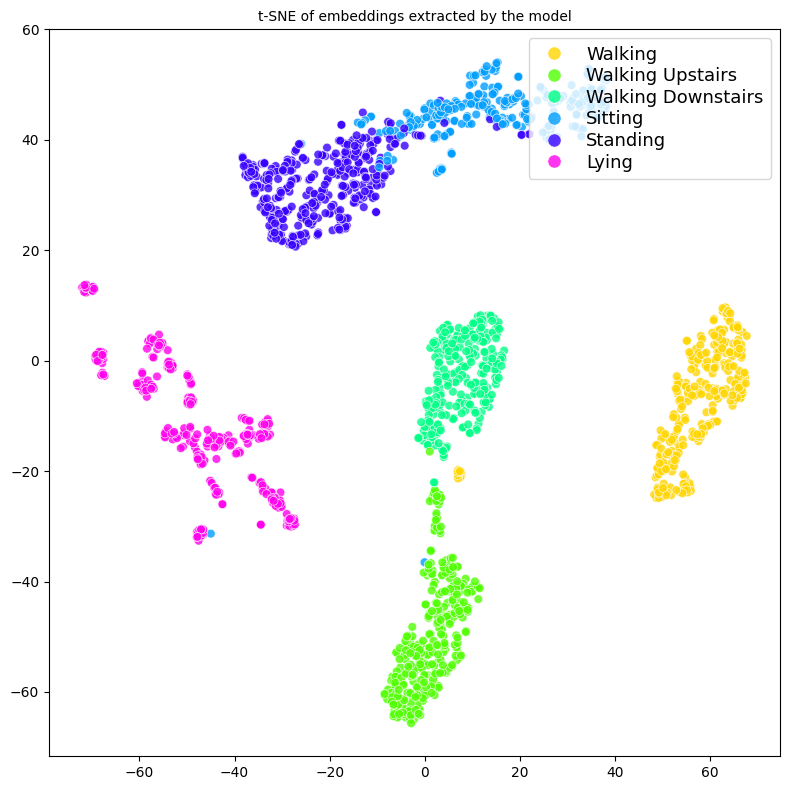


Saved artifacts to: /content/drive/MyDrive/Colab Notebooks/HAR/PADRe/Overall-Results/UCI-HAR
 - ckpt: /content/drive/MyDrive/Colab Notebooks/HAR/PADRe/Overall-Results/UCI-HAR/best_by_macro_f1.ckpt
 - npy : X_train/X_test/y_train/y_test
 - png : confusion_matrix.png, tsne_embeddings.png


In [1]:
import os, copy, random, time
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)
from sklearn.manifold import TSNE
from fvcore.nn import FlopCountAnalysis

# ──────────────────────────────────────────────────────────────────────────────
# Seed / Device
# ──────────────────────────────────────────────────────────────────────────────
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = DEVICE.type == "cuda"
print(f"Device: {DEVICE} | pin_memory: {USE_GPU}")


# ──────────────────────────────────────────────────────────────────────────────
# Dataset
# ──────────────────────────────────────────────────────────────────────────────
CLASS_NAMES = ["WALK", "UP", "DOWN", "SIT", "STAND", "LAY"]

class UCIHARDataset(Dataset):
    def __init__(self, data_dir, split="train", normalize=None):
        self.data_dir = Path(data_dir)
        self.split    = split
        self.X, self.y = self._load_data()
        self.X = torch.FloatTensor(self.X)
        self.y = torch.LongTensor(self.y) - 1

        self.normalize = normalize

    def _load_data(self):
        split_dir    = self.data_dir / self.split
        signal_types = [
            "body_acc_x","body_acc_y","body_acc_z",
            "body_gyro_x","body_gyro_y","body_gyro_z",
            "total_acc_x","total_acc_y","total_acc_z",
        ]
        signals = []
        for st in signal_types:
            fname = split_dir / "Inertial Signals" / f"{st}_{self.split}.txt"
            signals.append(np.loadtxt(fname))
        X = np.stack(signals, axis=1)
        y = np.loadtxt(split_dir / f"y_{self.split}.txt", dtype=int)
        return X, y

    def __len__(self):  return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        if self.normalize is not None:
            mean, std = self.normalize
            X = (X - mean.squeeze(0)) / std.squeeze(0)
        return X, y


# ──────────────────────────────────────────────────────────────────────────────
# Compute-Aware Degree Gate
# ──────────────────────────────────────────────────────────────────────────────
class ComputeAwareDegreeGate(nn.Module):
    def __init__(self,
                 channels,
                 max_degree=3,
                 gate_hidden_dim=16,
                 temperature_initial=5.0,
                 temperature_min=0.5
        ):
        super().__init__()
        self.max_degree = max_degree

        self.gate = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(1),
            nn.Linear(channels, gate_hidden_dim),
            nn.GELU(),
            nn.Linear(gate_hidden_dim, max_degree),
        )

        nn.init.zeros_(self.gate[-1].bias)
        if max_degree >= 3:
            self.gate[-1].bias.data[1] = 0.4
        self.register_buffer("temperature", torch.tensor(float(temperature_initial)))
        self.temperature_min = float(temperature_min)

    def set_temperature(self, t):
        self.temperature.fill_(max(float(t), self.temperature_min))

    def forward(self, x):
        logits = self.gate(x)
        soft_probs = F.softmax(logits / self.temperature, dim=-1)

        if self.training:
            hard_idx = logits.argmax(dim=-1)
            hard_oh = F.one_hot(hard_idx, num_classes=self.max_degree).float()
            degree_w = hard_oh - soft_probs.detach() + soft_probs
        else:
            degree_w = F.one_hot(logits.argmax(dim=-1), num_classes=self.max_degree).float()

        return degree_w, logits, soft_probs


# ──────────────────────────────────────────────────────────────────────────────
# PADRe Block
# ──────────────────────────────────────────────────────────────────────────────
class PADReBlock(nn.Module):
    def __init__(self,
                 channels,
                 seq_len,
                 max_degree=3,
                 token_kernel=11,
                 gate_hidden_dim=16,
                 temperature_initial=5.0,
                 temperature_min=0.5,
        ):
        super().__init__()
        self.max_degree = max_degree

        self.degree_gate = ComputeAwareDegreeGate(
            channels,
            max_degree=max_degree,
            gate_hidden_dim=gate_hidden_dim,
            temperature_initial=temperature_initial,
            temperature_min=temperature_min
        )

        self.channel_mixing = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=1) for _ in range(max_degree)
        ])

        self.token_mixing = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=token_kernel,
                      padding=token_kernel // 2, groups=channels)
            for _ in range(max_degree)
        ])

        self.pre_hadamard_channel = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=1) for _ in range(max_degree-1)
        ])

        self.pre_hadamard_token = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=token_kernel,
                      padding=token_kernel // 2, groups=channels)
            for _ in range(max_degree-1)
        ])

        self.norm = nn.LayerNorm(channels)

    def _build_Z(self, x, max_deg):
        Y = [self.token_mixing[i](self.channel_mixing[i](x)) for i in range(max_deg)]
        Z = [Y[0]]
        for i in range(1, max_deg):
            Z_ = self.pre_hadamard_token[i-1](self.pre_hadamard_channel[i-1](Z[-1]))
            Z.append(Z_ * Y[i])
        return Z

    def _hard_forward(self, x, sel):
        B = x.shape[0]
        max_deg = max(1, min(int(sel.max().item()) + 1, self.max_degree))
        Z = self._build_Z(x, max_deg)
        Z_stack = torch.stack(Z, dim=0)
        return Z_stack[sel, torch.arange(B, device=x.device)]

    def forward(self, x, return_gate_info=False):
        dw, logits, sp = self.degree_gate(x)
        sel = dw.argmax(dim=-1)
        out = self._hard_forward(x, sel)

        out = self.norm(out.permute(0, 2, 1)).permute(0, 2, 1)

        if return_gate_info:
            return out, {
                "degree_selection": dw,
                "soft_probs": sp,
                "logits": logits,
                "compute_cost": (sel + 1).float().mean().item()
            }
        return out


# ──────────────────────────────────────────────────────────────────────────────
# Adaptive PADRe Model
# ──────────────────────────────────────────────────────────────────────────────
class PADReHAR(nn.Module):
    def __init__(self,
                 in_channels=9,
                 seq_len=128,
                 num_classes=6,
                 hidden_dim=48,
                 num_layers=3,
                 max_degree=3,
                 gate_hidden_dim=16,
                 dropout=0.2,
                 temperature_initial=5.0,
                 temperature_min=0.5,
        ):
        super().__init__()
        self.num_layers = num_layers
        self.max_degree = max_degree

        self.input_proj = nn.Conv1d(in_channels, hidden_dim, kernel_size=1)

        self.padre_blocks = nn.ModuleList([
            PADReBlock(hidden_dim, seq_len, max_degree=max_degree, token_kernel=11,
                       gate_hidden_dim=gate_hidden_dim,
                       temperature_initial=temperature_initial,
                       temperature_min=temperature_min)
            for _ in range(num_layers)
        ])


        self.ffn = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(hidden_dim, hidden_dim * 2, kernel_size=1),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Conv1d(hidden_dim * 2, hidden_dim, kernel_size=1),
                nn.Dropout(dropout),
            )
            for _ in range(num_layers)
        ])

        self.norms1 = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])
        self.norms2 = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    def set_temperature(self, t):
        for b in self.padre_blocks:
            b.degree_gate.set_temperature(t)

    def _ln(self, norm, x):
        return norm(x.permute(0, 2, 1)).permute(0, 2, 1)

    def forward(self, x, return_gate_info=False, return_details=False):
        x = self.input_proj(x)
        gate_info_list = [] if return_gate_info else None
        total_compute  = 0.0

        for i, block in enumerate(self.padre_blocks):
            res = x

            if return_gate_info:
                x, gi = block(x, return_gate_info=True)
                gate_info_list.append(gi)
                total_compute += gi["compute_cost"]
            else:
                x = block(x)

            x = self._ln(self.norms1[i], x + res)

            res2 = x
            x = self.ffn[i](x)
            x = self._ln(self.norms2[i], x + res2)

        h = self.global_pool(x).squeeze(-1)
        logits = self.classifier(h)

        if return_gate_info:
            return logits, gate_info_list, total_compute
        if return_details:
            return logits, {"h": h}
        return logits


# ──────────────────────────────────────────────────────────────────────────────
# Utils
# ──────────────────────────────────────────────────────────────────────────────
def cosine_temperature(ep, total, tmax=5.0, tmin=0.5):
    r = ep / max(total - 1, 1)
    return tmin + (tmax - tmin) * 0.5 * (1.0 + np.cos(np.pi * r))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def params_in_millions(model: nn.Module) -> float:
    return count_parameters(model) / 1e6

@torch.no_grad()
def compute_train_stats(train_loader, device="cpu", eps=1e-6):
    """
    Returns:
      mean: (C,1) tensor
      std : (C,1) tensor
    Note:
      X shape from loader: (B,C,T)
      We compute stats over (B,T) for each channel.
    """
    sum_x = None
    sum_x2 = None
    n = 0

    for X, _ in train_loader:
        X = X.to(device)  # (B,C,T)
        B, C, T = X.shape
        if sum_x is None:
            sum_x = torch.zeros(C, device=device)
            sum_x2 = torch.zeros(C, device=device)

        # sum over batch and time
        sum_x  += X.sum(dim=(0, 2))                 # (C,)
        sum_x2 += (X * X).sum(dim=(0, 2))           # (C,)
        n += B * T

    mean = (sum_x / n)                              # (C,)
    var  = (sum_x2 / n) - mean * mean               # (C,)
    std  = torch.sqrt(torch.clamp(var, min=eps))    # (C,)

    # reshape for broadcasting: (1,C,1) or (C,1)
    mean = mean.view(1, -1, 1)
    std  = std.view(1, -1, 1)
    return mean.detach().cpu(), std.detach().cpu()

@torch.no_grad()
def compute_flops_m(model: nn.Module, input_shape=(1, 9, 128), device="cpu") -> float:
    model_eval = copy.deepcopy(model).to(device)
    model_eval.eval()
    x = torch.randn(*input_shape, device=device)
    flops = FlopCountAnalysis(model_eval, x).total()
    return flops / 1e6

@torch.no_grad()
def measure_cpu_infer_time_ms_clean(model, input_shape, warmup=50, runs=300):
    m = copy.deepcopy(model).cpu().eval()
    x = torch.randn(*input_shape)

    with torch.inference_mode():
        for _ in range(warmup):
            _ = m(x)
        t0 = time.perf_counter()
        for _ in range(runs):
            _ = m(x)
        t1 = time.perf_counter()

    return (t1 - t0) / runs * 1000.0

@torch.no_grad()
def evaluate_best_model(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        pred = logits.argmax(dim=1).detach().cpu().numpy()
        y_pred.append(pred)
        y_true.append(yb.numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return {
        "acc": acc,
        "macro_precision": prec,
        "macro_recall": rec,
        "macro_f1": f1,
        "y_true": y_true,
        "y_pred": y_pred,
    }

def save_arrays_npy(train_dataset: UCIHARDataset, test_dataset: UCIHARDataset, out_dir: str):
    os.makedirs(out_dir, exist_ok=True)
    np.save(os.path.join(out_dir, "X_train.npy"), train_dataset.X.numpy())
    np.save(os.path.join(out_dir, "y_train.npy"), train_dataset.y.numpy())
    np.save(os.path.join(out_dir, "X_test.npy"),  test_dataset.X.numpy())
    np.save(os.path.join(out_dir, "y_test.npy"),  test_dataset.y.numpy())

def save_ckpt(model: nn.Module, best_f1: float, config: dict, out_path: str):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    torch.save(
        {
            "state_dict": model.state_dict(),
            "best_macro_f1": float(best_f1),
            "config": config,
        },
        out_path
    )

ACTIVITY_LABELS_CM = [
    "Walking",
    "Walking Upstairs".replace(" ", "\n"),
    "Walking Downstairs".replace(" ", "\n"),
    "Sitting",
    "Standing",
    "Lying",
]

ACTIVITY_LABELS = [
    "Walking",
    "Walking Upstairs",
    "Walking Downstairs",
    "Sitting",
    "Standing",
    "Lying",
]

n_labels = len(ACTIVITY_LABELS)
hsv_colors = sns.color_palette("hsv", n_colors=n_labels)
ACTIVITY_COLOR_MAP = dict(zip(ACTIVITY_LABELS, hsv_colors))

def plot_classification_results(y_true, y_pred, save_path=None):
    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=ACTIVITY_LABELS,
            digits=4,
            zero_division=0,
        )
    )

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', square=True,
                annot_kws={"size": 22}, cbar_kws={"shrink": 0.7},
                xticklabels=ACTIVITY_LABELS_CM, yticklabels=ACTIVITY_LABELS_CM)
    plt.xlabel('Predicted Label', fontsize=12.5)
    plt.ylabel('True Label', fontsize=11)
    plt.title('')
    plt.xticks(rotation=90, ha='right', fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600)

    plt.show()
    plt.close()

def _extract_featvec_before_classifier(model, xb, device):
    xb = xb.to(device)
    _, details = model(xb, return_details=True)
    feat_vec = details["h"]
    return feat_vec.detach().cpu()

def plot_tsne_from_cached_features(feats, labels, save_path=None, max_points=2000):
    all_features = feats
    all_labels = labels

    N = all_features.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_features[idx]
    y_sel = all_labels[idx]

    effective_perp = min(30, len(X_sel) - 1)
    effective_perp = max(effective_perp, 5)

    print(f"\nRunning t-SNE on {len(X_sel)} points (Perplexity={effective_perp})...")

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_sel)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40,
    )
    plt.title("t-SNE of embeddings extracted by the model", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300)

    plt.show()
    plt.close()

def visualize_tsne_raw(dataloader, save_path=None, max_points=2000):
    all_raw = []
    all_labels = []

    for xb, yb in dataloader:
        all_raw.append(xb.cpu().numpy())
        all_labels.append(yb.cpu().numpy())

    all_raw = np.concatenate(all_raw, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    N = all_raw.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_raw[idx]
    y_sel = all_labels[idx]

    X_flat = X_sel.reshape(X_sel.shape[0], -1)

    effective_perp = min(30, len(X_flat) - 1)
    effective_perp = max(effective_perp, 5)

    print(f"\nRunning Raw Data t-SNE on {len(X_sel)} points...")

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_flat)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40,
    )
    plt.title("t-SNE of raw data before model processing", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300)

    plt.show()
    plt.close()

@torch.no_grad()
def cache_embeddings_from_loader(model, loader, device, max_batches=None):
    model.eval()
    feats_list = []
    labels_list = []

    for b, (xb, yb) in enumerate(loader):
        xb = xb.to(device, non_blocking=True)
        logits, details = model(xb, return_details=True)
        feats_list.append(details["h"].detach().cpu().numpy())
        labels_list.append(yb.numpy())

        if (max_batches is not None) and (b + 1 >= max_batches):
            break

    feats = np.concatenate(feats_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return feats, labels


# ──────────────────────────────────────────────────────────────────────────────
# Train & Eval
# ──────────────────────────────────────────────────────────────────────────────
def train_model(model,
                train_loader,
                test_loader,
                device,
                lr=1e-3,
                weight_decay=1e-4,
                epochs=30,
                seed=42
    ):
    set_seed(seed)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.01)

    best_f1 = -1.0
    best_state = None

    for ep in range(epochs):
        temp = cosine_temperature(ep, epochs, tmax=5.0, tmin=0.5)
        model.set_temperature(temp)

        model.train()
        train_loss_sum = 0.0
        train_n = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            bs = y.size(0)
            train_loss_sum += loss.item() * bs
            train_n += bs

        scheduler.step()
        train_loss = train_loss_sum / max(train_n, 1)

        model.eval()
        preds_all, labels_all = [], []
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                preds_all.extend(model(X).argmax(1).cpu().numpy())
                labels_all.extend(y.cpu().numpy())
        test_f1 = f1_score(labels_all, preds_all, average="macro")

        if test_f1 > best_f1:
            best_f1 = test_f1
            best_state = copy.deepcopy(model.state_dict())

        if (ep + 1) % 5 == 0:
            cur_lr = optimizer.param_groups[0]["lr"]
            print(f"Epoch {ep+1:02d}/{epochs} | LR={cur_lr:.4f} | Train Loss={train_loss:.4f} | TestF1={test_f1:.4f} | BestF1={best_f1:.4f} | Temp={temp:.3f}")

    model.load_state_dict(best_state)
    print(f"\nBest Test Macro-F1: {best_f1:.4f}")
    return model, best_f1


# ──────────────────────────────────────────────────────────────────────────────
# Main
# ──────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/HAR/har_orig_datasets/UCI_HAR"
    OUT_DIR = "/content/drive/MyDrive/Colab Notebooks/HAR/PADRe/Overall-Results/UCI-HAR"
    SEED = 42
    NUM_WORKERS = 2 if USE_GPU else 0
    PIN_MEMORY = USE_GPU

    BATCH_SIZE = 128
    EPOCHS = 100
    NUM_CLASSES = 6
    HIDDEN_DIM = 48
    NUM_LAYERS = 3
    MAX_DEGREE = 3
    GATE_HIDDEN_DIM = 16
    DROPOUT = 0.3
    LR = 2e-3
    WD = 1e-2

    os.makedirs(OUT_DIR, exist_ok=True)

    train_dataset_raw = UCIHARDataset(DATA_PATH, split="train", normalize=None)

    stats_loader = DataLoader(
        train_dataset_raw,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False
    )

    mean, std = compute_train_stats(stats_loader, device=DEVICE if USE_GPU else "cpu")
    train_dataset = UCIHARDataset(DATA_PATH, split="train", normalize=(mean, std))
    test_dataset  = UCIHARDataset(DATA_PATH, split="test",  normalize=(mean, std))

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    set_seed(SEED)
    model = PADReHAR(in_channels=9,
                     seq_len=128,
                     num_classes=NUM_CLASSES,
                     hidden_dim=HIDDEN_DIM,
                     num_layers=NUM_LAYERS,
                     max_degree=MAX_DEGREE,
                     gate_hidden_dim=GATE_HIDDEN_DIM,
                     dropout=DROPOUT,
                     temperature_initial=5.0,
                     temperature_min=0.5
                     ).to(DEVICE)
    print(f"\nModel params: {count_parameters(model):,}\n")

    model, best_f1 = train_model(model, train_loader, test_loader, DEVICE,
                        lr=LR, weight_decay=WD, epochs=EPOCHS, seed=SEED)

    test_metrics = evaluate_best_model(model, test_loader, DEVICE)

    # Params / FLOPs / CPU infer time
    cpu_ms   = measure_cpu_infer_time_ms_clean(model, input_shape=(1, 9, 128))
    params_m = params_in_millions(model)
    flops_m  = compute_flops_m(model, input_shape=(1, 9, 128), device="cpu")  # device에서 측정

    print("\n" + "="*80)
    print("Best Model Summary (selected by Best Test Macro-F1)")
    print("="*80)
    print(f"Accuracy          : {test_metrics['acc']:.4f}")
    print(f"Macro Precision   : {test_metrics['macro_precision']:.4f}")
    print(f"Macro Recall      : {test_metrics['macro_recall']:.4f}")
    print(f"Macro F1          : {test_metrics['macro_f1']:.4f}")
    print(f"Params (M)        : {params_m:.3f}")
    print(f"FLOPs (M)         : {flops_m:.3f}")
    print(f"CPU infer time(ms): {cpu_ms:.3f} (batch=1)")

    # Save ckpt + npy
    config = dict(
        seed=SEED,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        num_classes=NUM_CLASSES,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS,
        max_degree=MAX_DEGREE,
        gate_hidden_dim=GATE_HIDDEN_DIM,
        dropout=DROPOUT,
        lr=LR,
        weight_decay=WD,
        data_path=DATA_PATH,
    )

    ckpt_path = os.path.join(OUT_DIR, "best_by_macro_f1.ckpt")
    save_ckpt(model, best_f1, config, ckpt_path)
    save_arrays_npy(train_dataset, test_dataset, OUT_DIR)

    # CM
    cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
    plot_classification_results(
        y_true=test_metrics["y_true"],
        y_pred=test_metrics["y_pred"],
        save_path=cm_path
    )

    # t-SNE (embeddings)
    feats, labels = cache_embeddings_from_loader(model, test_loader, DEVICE)
    tsne_path = os.path.join(OUT_DIR, "tsne_embeddings.png")
    plot_tsne_from_cached_features(feats, labels, save_path=tsne_path, max_points=2000)

    print("\nSaved artifacts to:", OUT_DIR)
    print(" - ckpt:", ckpt_path)
    print(" - npy : X_train/X_test/y_train/y_test")
    print(" - png : confusion_matrix.png, tsne_embeddings.png")

# PAMAP2

Device: cuda | pin_memory: True


/tmp/ipython-input-2454859500.py:177: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("subject_id", group_keys=False).apply(_fill_subject_group)


Loaded PAMAP2 dataset
X shape : (38862, 27, 100)  (N, C, T)
y shape : (38862,)  (N,)
Classes : 12

Model params: 79,749

Epoch 05/100 | LR=0.0020 | Train Loss=0.3251 | TestF1=0.9200 | BestF1=0.9200 | Temp=4.982
Epoch 10/100 | LR=0.0020 | Train Loss=0.2357 | TestF1=0.9369 | BestF1=0.9378 | Temp=4.909
Epoch 15/100 | LR=0.0019 | Train Loss=0.1852 | TestF1=0.9475 | BestF1=0.9499 | Temp=4.782
Epoch 20/100 | LR=0.0018 | Train Loss=0.1584 | TestF1=0.9578 | BestF1=0.9585 | Temp=4.603
Epoch 25/100 | LR=0.0017 | Train Loss=0.1392 | TestF1=0.9641 | BestF1=0.9641 | Temp=4.378
Epoch 30/100 | LR=0.0016 | Train Loss=0.1251 | TestF1=0.9642 | BestF1=0.9663 | Temp=4.113
Epoch 35/100 | LR=0.0015 | Train Loss=0.1134 | TestF1=0.9686 | BestF1=0.9697 | Temp=3.813
Epoch 40/100 | LR=0.0013 | Train Loss=0.1083 | TestF1=0.9723 | BestF1=0.9725 | Temp=3.486
Epoch 45/100 | LR=0.0012 | Train Loss=0.1007 | TestF1=0.9755 | BestF1=0.9759 | Temp=3.141
Epoch 50/100 | LR=0.0010 | Train Loss=0.0943 | TestF1=0.9761 | BestF1

padre_blocks.0.channel_mixing.2, padre_blocks.0.pre_hadamard_channel.1, padre_blocks.0.pre_hadamard_token.1, padre_blocks.0.token_mixing.2, padre_blocks.1.channel_mixing.2, padre_blocks.1.pre_hadamard_channel.1, padre_blocks.1.pre_hadamard_token.1, padre_blocks.1.token_mixing.2, padre_blocks.2.channel_mixing.2, padre_blocks.2.pre_hadamard_channel.1, padre_blocks.2.pre_hadamard_token.1, padre_blocks.2.token_mixing.2



Best Model Summary (selected by Best Test Macro-F1)
Accuracy          : 0.9851
Macro Precision   : 0.9864
Macro Recall      : 0.9827
Macro F1          : 0.9845
Params (M)        : 0.080
FLOPs (M)         : 5.665
CPU infer time(ms): 4.996 (batch=1)

Classification Report
                   precision    recall  f1-score   support

            Lying     1.0000    0.9893    0.9946       745
          Sitting     0.9827    0.9933    0.9880       743
         Standing     0.9818    0.9882    0.9850       763
          Walking     0.9900    0.9950    0.9925       992
          Running     0.9947    0.9792    0.9869       384
          Cycling     0.9935    0.9952    0.9944       619
   Nordic walking     0.9974    0.9910    0.9942       777
 Ascending stairs     0.9776    0.9820    0.9798       445
Descending stairs     0.9814    0.9635    0.9724       438
  Vacuum cleaning     0.9725    0.9655    0.9690       696
          Ironing     0.9650    0.9832    0.9740       954
     Rope jumping  

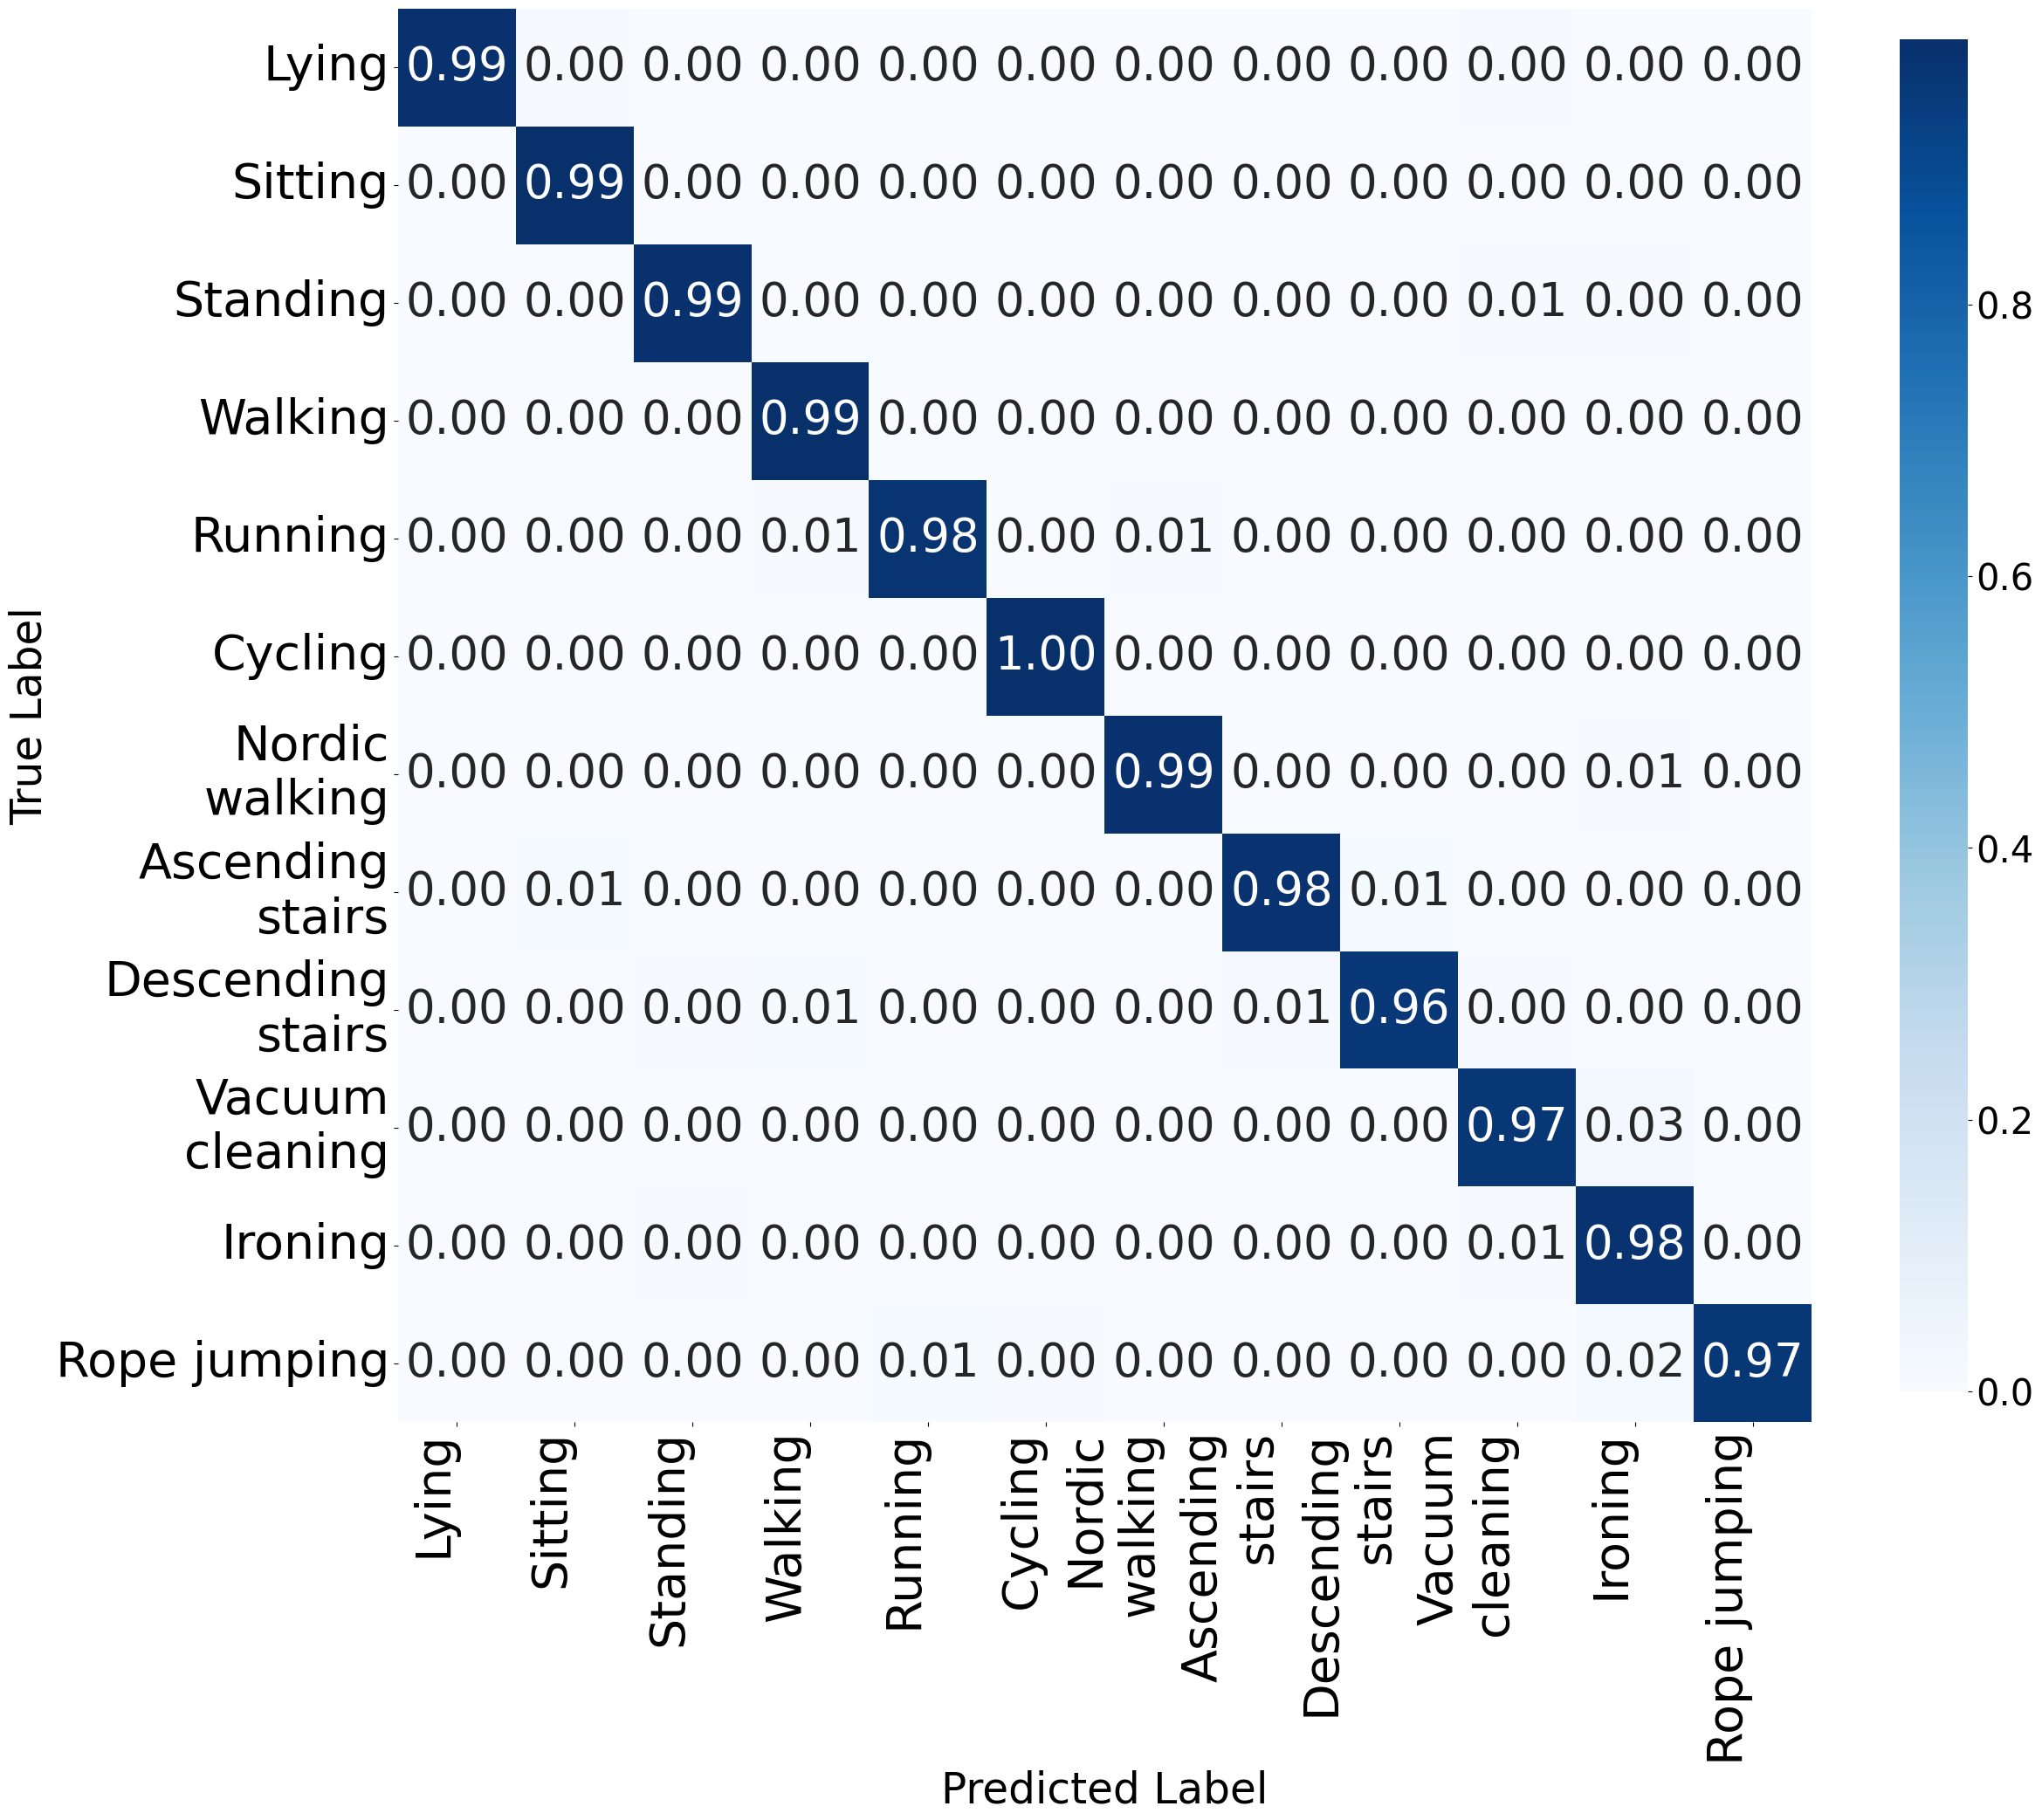


Running t-SNE on 2000 points (Perplexity=30)...


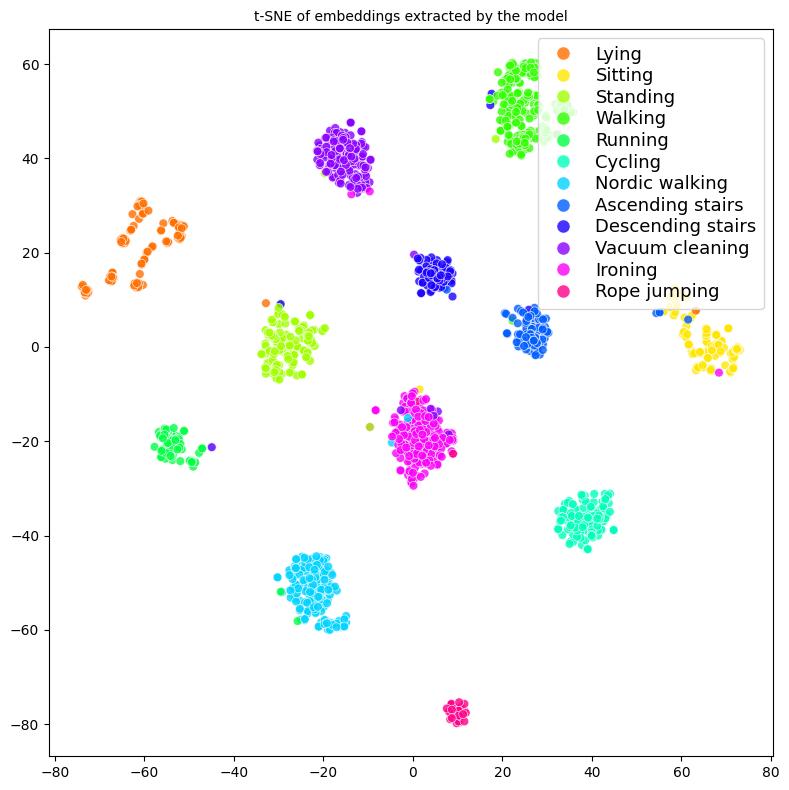


Saved artifacts to: /content/drive/MyDrive/Colab Notebooks/HAR/PADRe/Overall-Results/PAMAP2
 - ckpt: /content/drive/MyDrive/Colab Notebooks/HAR/PADRe/Overall-Results/PAMAP2/best_by_macro_f1.ckpt
 - npy : X_train/X_test/y_train/y_test
 - png : confusion_matrix.png, tsne_embeddings.png


In [1]:
import os, copy, random, time, re, glob
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from fvcore.nn import FlopCountAnalysis

# ──────────────────────────────────────────────────────────────────────────────
# Seed / Device
# ──────────────────────────────────────────────────────────────────────────────
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = DEVICE.type == "cuda"
print(f"Device: {DEVICE} | pin_memory: {USE_GPU}")


# ──────────────────────────────────────────────────────────────────────────────
# Dataset
# ──────────────────────────────────────────────────────────────────────────────
def create_pamap2_windows(df: pd.DataFrame, window_size: int, step_size: int):
    feature_cols = [
        # hand
        "handAcc16_1","handAcc16_2","handAcc16_3",
        "handAcc6_1","handAcc6_2","handAcc6_3",
        "handGyro1","handGyro2","handGyro3",
        # chest
        "chestAcc16_1","chestAcc16_2","chestAcc16_3",
        "chestAcc6_1","chestAcc6_2","chestAcc6_3",
        "chestGyro1","chestGyro2","chestGyro3",
        # ankle
        "ankleAcc16_1","ankleAcc16_2","ankleAcc16_3",
        "ankleAcc6_1","ankleAcc6_2","ankleAcc6_3",
        "ankleGyro1","ankleGyro2","ankleGyro3",
    ]  # C = 27

    ORDERED_IDS = [1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]
    old2new = {
        1: 0,   # Lying
        2: 1,   # Sitting
        3: 2,   # Standing
        4: 3,   # Walking
        5: 4,   # Running
        6: 5,   # Cycling
        7: 6,   # Nordic walking
        12: 7,  # Ascending stairs
        13: 8,  # Descending stairs
        16: 9,  # Vacuum cleaning
        17: 10, # Ironing
        24: 11, # Rope jumping
    }
    label_names = [
        "Lying", "Sitting", "Standing", "Walking",
        "Running", "Cycling", "Nordic walking",
        "Ascending stairs", "Descending stairs",
        "Vacuum cleaning", "Ironing", "Rope jumping",
    ]

    X_list, y_list, subj_list = [], [], []

    for subj_id, g in df.groupby("subject_id"):
        if "timestamp" in g.columns:
            g = g.sort_values("timestamp")
        else:
            g = g.sort_index()

        data_arr  = g[feature_cols].to_numpy(dtype=np.float32)
        label_arr = g["activityID"].to_numpy(dtype=np.int64)
        L = data_arr.shape[0]

        start = 0
        while start + window_size <= L:
            end = start + window_size
            last_label_orig = int(label_arr[end - 1])

            if last_label_orig == 0:
                start += step_size
                continue
            if last_label_orig not in old2new:
                start += step_size
                continue

            window_ct = data_arr[start:end].T
            X_list.append(window_ct)
            y_list.append(old2new[last_label_orig])
            subj_list.append(int(subj_id))
            start += step_size

    if len(X_list) == 0:
        raise RuntimeError("No windows created. Check window_size/step_size and label filtering.")

    X = np.stack(X_list, axis=0).astype(np.float32)
    y = np.asarray(y_list, dtype=np.int64)
    subj_ids = np.asarray(subj_list, dtype=np.int64)
    return X, y, subj_ids, label_names


class PAMAP2Dataset(Dataset):
    def __init__(self, data_dir, window_size, step_size):
        super().__init__()

        csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
        if len(csv_files) == 0:
            raise RuntimeError(f"No CSV files found under {data_dir}")

        dfs = []
        for fpath in sorted(csv_files):
            df_i = pd.read_csv(fpath)

            if "subject_id" not in df_i.columns:
                m = re.findall(r"\d+", os.path.basename(fpath))
                subj_guess = int(m[0]) if len(m) > 0 else 0
                df_i["subject_id"] = subj_guess

            dfs.append(df_i)

        df = pd.concat(dfs, ignore_index=True)

        df = df.dropna(subset=["activityID"])
        df["activityID"] = df["activityID"].astype(np.int64)
        df["subject_id"] = df["subject_id"].astype(np.int64)
        if "timestamp" in df.columns:
            df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")

        feature_cols = [
            # hand
            "handAcc16_1","handAcc16_2","handAcc16_3",
            "handAcc6_1","handAcc6_2","handAcc6_3",
            "handGyro1","handGyro2","handGyro3",
            # chest
            "chestAcc16_1","chestAcc16_2","chestAcc16_3",
            "chestAcc6_1","chestAcc6_2","chestAcc6_3",
            "chestGyro1","chestGyro2","chestGyro3",
            # ankle
            "ankleAcc16_1","ankleAcc16_2","ankleAcc16_3",
            "ankleAcc6_1","ankleAcc6_2","ankleAcc6_3",
            "ankleGyro1","ankleGyro2","ankleGyro3",
        ]

        def _fill_subject_group(g):
            if "timestamp" in g.columns:
                g = g.sort_values("timestamp")
            else:
                g = g.sort_index()
            g[feature_cols] = (
                g[feature_cols]
                .interpolate(method="linear", limit_direction="both", axis=0)
                .ffill()
                .bfill()
            )
            return g

        df = df.groupby("subject_id", group_keys=False).apply(_fill_subject_group)
        df[feature_cols] = df[feature_cols].fillna(0.0)

        X, y, subj_ids, label_names = create_pamap2_windows(df, window_size, step_size)

        self.X = X.astype(np.float32)
        self.y = y
        self.subject_ids = subj_ids
        self.label_names = label_names
        self.scaler = None

    def fit_scaler(self, indices):
        Xtr = self.X[indices]
        N, C, T = Xtr.shape

        X2 = np.transpose(Xtr, (0, 2, 1)).reshape(-1, C)

        scaler = StandardScaler()
        scaler.fit(X2)
        self.scaler = scaler
        return scaler

    def apply_scaler(self, scaler=None):
        if scaler is None:
            scaler = self.scaler
        assert scaler is not None, "Scaler is not fitted. Call fit_scaler() first."

        X = self.X
        N, C, T = X.shape
        X2 = np.transpose(X, (0, 2, 1)).reshape(-1, C)
        X2 = scaler.transform(X2)
        X_scaled = X2.reshape(N, T, C).transpose(0, 2, 1)

        self.X = X_scaled.astype(np.float32)

        print("Loaded PAMAP2 dataset")
        print(f"X shape : {self.X.shape}  (N, C, T)")
        print(f"y shape : {self.y.shape}  (N,)")
        print(f"Classes : {len(self.label_names)}")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]).float(),
            torch.tensor(self.y[idx], dtype=torch.long),
            int(self.subject_ids[idx]),
        )


# ──────────────────────────────────────────────────────────────────────────────
# Compute-Aware Degree Gate
# ──────────────────────────────────────────────────────────────────────────────
class ComputeAwareDegreeGate(nn.Module):
    def __init__(self,
                 channels,
                 max_degree=3,
                 gate_hidden_dim=16,
                 temperature_initial=5.0,
                 temperature_min=0.5
        ):
        super().__init__()
        self.max_degree = max_degree

        self.gate = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(1),
            nn.Linear(channels, gate_hidden_dim),
            nn.GELU(),
            nn.Linear(gate_hidden_dim, max_degree),
        )

        nn.init.zeros_(self.gate[-1].bias)
        if max_degree >= 3:
            self.gate[-1].bias.data[1] = 0.4
        self.register_buffer("temperature", torch.tensor(float(temperature_initial)))
        self.temperature_min = float(temperature_min)

    def set_temperature(self, t):
        self.temperature.fill_(max(float(t), self.temperature_min))

    def forward(self, x):
        logits = self.gate(x)
        soft_probs = F.softmax(logits / self.temperature, dim=-1)

        if self.training:
            hard_idx = logits.argmax(dim=-1)
            hard_oh = F.one_hot(hard_idx, num_classes=self.max_degree).float()
            degree_w = hard_oh - soft_probs.detach() + soft_probs
        else:
            degree_w = F.one_hot(logits.argmax(dim=-1), num_classes=self.max_degree).float()

        return degree_w, logits, soft_probs


# ──────────────────────────────────────────────────────────────────────────────
# PADRe Block
# ──────────────────────────────────────────────────────────────────────────────
class PADReBlock(nn.Module):
    def __init__(self,
                 channels,
                 seq_len,
                 max_degree=3,
                 token_kernel=11,
                 gate_hidden_dim=16,
                 temperature_initial=5.0,
                 temperature_min=0.5,
        ):
        super().__init__()
        self.max_degree = max_degree

        self.degree_gate = ComputeAwareDegreeGate(
            channels,
            max_degree=max_degree,
            gate_hidden_dim=gate_hidden_dim,
            temperature_initial=temperature_initial,
            temperature_min=temperature_min
        )

        self.channel_mixing = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=1) for _ in range(max_degree)
        ])

        self.token_mixing = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=token_kernel,
                      padding=token_kernel // 2, groups=channels)
            for _ in range(max_degree)
        ])

        self.pre_hadamard_channel = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=1) for _ in range(max_degree-1)
        ])

        self.pre_hadamard_token = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=token_kernel,
                      padding=token_kernel // 2, groups=channels)
            for _ in range(max_degree-1)
        ])

        self.norm = nn.LayerNorm(channels)

    def _build_Z(self, x, max_deg):
        Y = [self.token_mixing[i](self.channel_mixing[i](x)) for i in range(max_deg)]
        Z = [Y[0]]
        for i in range(1, max_deg):
            Z_ = self.pre_hadamard_token[i-1](self.pre_hadamard_channel[i-1](Z[-1]))
            Z.append(Z_ * Y[i])
        return Z

    def _hard_forward(self, x, sel):
        B = x.shape[0]
        max_deg = max(1, min(int(sel.max().item()) + 1, self.max_degree))
        Z = self._build_Z(x, max_deg)
        Z_stack = torch.stack(Z, dim=0)
        return Z_stack[sel, torch.arange(B, device=x.device)]

    def forward(self, x, return_gate_info=False):
        dw, logits, sp = self.degree_gate(x)
        sel = dw.argmax(dim=-1)
        out = self._hard_forward(x, sel)

        out = self.norm(out.permute(0, 2, 1)).permute(0, 2, 1)

        if return_gate_info:
            return out, {
                "degree_selection": dw,
                "soft_probs": sp,
                "logits": logits,
                "compute_cost": (sel + 1).float().mean().item()
            }
        return out


# ──────────────────────────────────────────────────────────────────────────────
# Adaptive PADRe Model
# ──────────────────────────────────────────────────────────────────────────────
class PADReHAR(nn.Module):
    def __init__(self,
                 in_channels=9,
                 seq_len=128,
                 num_classes=6,
                 hidden_dim=48,
                 num_layers=3,
                 max_degree=3,
                 gate_hidden_dim=16,
                 dropout=0.2,
                 temperature_initial=5.0,
                 temperature_min=0.5,
        ):
        super().__init__()
        self.num_layers = num_layers
        self.max_degree = max_degree

        self.input_proj = nn.Conv1d(in_channels, hidden_dim, kernel_size=1)

        self.padre_blocks = nn.ModuleList([
            PADReBlock(hidden_dim, seq_len, max_degree=max_degree, token_kernel=11,
                       gate_hidden_dim=gate_hidden_dim,
                       temperature_initial=temperature_initial,
                       temperature_min=temperature_min)
            for _ in range(num_layers)
        ])


        self.ffn = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(hidden_dim, hidden_dim * 2, kernel_size=1),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Conv1d(hidden_dim * 2, hidden_dim, kernel_size=1),
                nn.Dropout(dropout),
            )
            for _ in range(num_layers)
        ])

        self.norms1 = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])
        self.norms2 = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    def set_temperature(self, t):
        for b in self.padre_blocks:
            b.degree_gate.set_temperature(t)

    def _ln(self, norm, x):
        return norm(x.permute(0, 2, 1)).permute(0, 2, 1)

    def forward(self, x, return_gate_info=False, return_details=False):
        x = self.input_proj(x)
        gate_info_list = [] if return_gate_info else None
        total_compute  = 0.0

        for i, block in enumerate(self.padre_blocks):
            res = x

            if return_gate_info:
                x, gi = block(x, return_gate_info=True)
                gate_info_list.append(gi)
                total_compute += gi["compute_cost"]
            else:
                x = block(x)

            x = self._ln(self.norms1[i], x + res)

            res2 = x
            x = self.ffn[i](x)
            x = self._ln(self.norms2[i], x + res2)

        h = self.global_pool(x).squeeze(-1)
        logits = self.classifier(h)

        if return_gate_info:
            return logits, gate_info_list, total_compute
        if return_details:
            return logits, {"h": h}
        return logits


# ──────────────────────────────────────────────────────────────────────────────
# Utils
# ──────────────────────────────────────────────────────────────────────────────
def cosine_temperature(ep, total, tmax=5.0, tmin=0.5):
    r = ep / max(total - 1, 1)
    return tmin + (tmax - tmin) * 0.5 * (1.0 + np.cos(np.pi * r))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def params_in_millions(model: nn.Module) -> float:
    return count_parameters(model) / 1e6

@torch.no_grad()
def compute_flops_m(model: nn.Module, input_shape=(1, 9, 128), device="cpu") -> float:
    model_eval = copy.deepcopy(model).to(device)
    model_eval.eval()
    x = torch.randn(*input_shape, device=device)
    flops = FlopCountAnalysis(model_eval, x).total()
    return flops / 1e6

@torch.no_grad()
def measure_cpu_infer_time_ms_clean(model, input_shape, warmup=50, runs=300):
    m = copy.deepcopy(model).cpu().eval()
    x = torch.randn(*input_shape)

    with torch.inference_mode():
        for _ in range(warmup):
            _ = m(x)
        t0 = time.perf_counter()
        for _ in range(runs):
            _ = m(x)
        t1 = time.perf_counter()

    return (t1 - t0) / runs * 1000.0

@torch.no_grad()
def evaluate_best_model(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb, _ in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        pred = logits.argmax(dim=1).detach().cpu().numpy()
        y_pred.append(pred)
        y_true.append(yb.numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return {
        "acc": acc,
        "macro_precision": prec,
        "macro_recall": rec,
        "macro_f1": f1,
        "y_true": y_true,
        "y_pred": y_pred,
    }

def save_arrays_npy_pamap2(full_dataset: PAMAP2Dataset, train_subset, test_subset, out_dir: str):
    os.makedirs(out_dir, exist_ok=True)

    tr_idx = np.array(train_subset.indices, dtype=np.int64)
    te_idx = np.array(test_subset.indices, dtype=np.int64)

    np.save(os.path.join(out_dir, "X_train.npy"), full_dataset.X[tr_idx])  # (N,C,T)
    np.save(os.path.join(out_dir, "y_train.npy"), full_dataset.y[tr_idx])
    np.save(os.path.join(out_dir, "subj_train.npy"), full_dataset.subject_ids[tr_idx])

    np.save(os.path.join(out_dir, "X_test.npy"),  full_dataset.X[te_idx])
    np.save(os.path.join(out_dir, "y_test.npy"),  full_dataset.y[te_idx])
    np.save(os.path.join(out_dir, "subj_test.npy"), full_dataset.subject_ids[te_idx])

def save_ckpt(model: nn.Module, best_f1: float, config: dict, out_path: str):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    torch.save(
        {
            "state_dict": model.state_dict(),
            "best_macro_f1": float(best_f1),
            "config": config,
        },
        out_path
    )

ACTIVITY_LABELS = [
    "Lying",
    "Sitting",
    "Standing",
    "Walking",
    "Running",
    "Cycling",
    "Nordic walking",
    "Ascending stairs",
    "Descending stairs",
    "Vacuum cleaning",
    "Ironing",
    "Rope jumping",
]

ACTIVITY_LABELS_CM = [
    "Lying",
    "Sitting",
    "Standing",
    "Walking",
    "Running",
    "Cycling",
    "Nordic walking",
    "Ascending\nstairs",
    "Descending\nstairs",
    "Vacuum\ncleaning",
    "Ironing",
    "Rope\njumping",
]

n_labels = len(ACTIVITY_LABELS)
hsv_colors = sns.color_palette("husl", n_colors=n_labels)
ACTIVITY_COLOR_MAP = dict(zip(ACTIVITY_LABELS, hsv_colors))


def plot_classification_results(y_true, y_pred, save_path=None):
    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=ACTIVITY_LABELS,
            digits=4,
            zero_division=0,
        )
    )

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(25, 25))
    ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', square=True,
                annot_kws={"size": 38}, cbar_kws={"shrink": 0.7},
                xticklabels=ACTIVITY_LABELS_CM, yticklabels=ACTIVITY_LABELS_CM)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)
    plt.xlabel('Predicted Label', fontsize=35)
    plt.ylabel('True Label', fontsize=35)
    plt.title('')
    plt.xticks(rotation=90, ha='right', fontsize=40)
    plt.yticks(rotation=0, fontsize=40)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600)

    plt.show()
    plt.close()

def _extract_featvec_before_classifier(model, xb, device):
    xb = xb.to(device)
    _, details = model(xb, return_details=True)
    feat_vec = details["h"]
    return feat_vec.detach().cpu()

def plot_tsne_from_cached_features(feats, labels, save_path=None, max_points=2000):
    all_features = feats
    all_labels = labels

    N = all_features.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_features[idx]
    y_sel = all_labels[idx]

    effective_perp = min(30, len(X_sel) - 1)
    effective_perp = max(effective_perp, 5)

    print(f"\nRunning t-SNE on {len(X_sel)} points (Perplexity={effective_perp})...")

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=30,
        early_exaggeration=24.0,
        max_iter=4000,
        init="pca",
        learning_rate="auto",
        metric="cosine",
        angle=0.5,
    )
    proj = tsne.fit_transform(X_sel)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40,
    )
    plt.title("t-SNE of embeddings extracted by the model", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300)

    plt.show()
    plt.close()

def visualize_tsne_raw(dataloader, save_path=None, max_points=2000):
    all_raw = []
    all_labels = []

    for xb, yb, _ in dataloader:
        all_raw.append(xb.cpu().numpy())
        all_labels.append(yb.cpu().numpy())

    all_raw = np.concatenate(all_raw, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    N = all_raw.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_raw[idx]
    y_sel = all_labels[idx]

    X_flat = X_sel.reshape(X_sel.shape[0], -1)

    effective_perp = min(30, len(X_flat) - 1)
    effective_perp = max(effective_perp, 5)

    print(f"\nRunning Raw Data t-SNE on {len(X_sel)} points...")

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_flat)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40,
    )
    plt.title("t-SNE of raw data before model processing", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300)

    plt.show()
    plt.close()

@torch.no_grad()
def cache_embeddings_from_loader(model, loader, device, max_batches=None):
    model.eval()
    feats_list = []
    labels_list = []

    for b, (xb, yb, _) in enumerate(loader):
        xb = xb.to(device, non_blocking=True)
        logits, details = model(xb, return_details=True)
        feats_list.append(details["h"].detach().cpu().numpy())
        labels_list.append(yb.numpy())

        if (max_batches is not None) and (b + 1 >= max_batches):
            break

    feats = np.concatenate(feats_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return feats, labels


# ──────────────────────────────────────────────────────────────────────────────
# Train & Eval
# ──────────────────────────────────────────────────────────────────────────────
def train_model(model,
                train_loader,
                test_loader,
                device,
                lr=1e-3,
                weight_decay=1e-4,
                epochs=30,
                seed=42
    ):
    set_seed(seed)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.01)

    best_f1 = -1.0
    best_state = None

    for ep in range(epochs):
        temp = cosine_temperature(ep, epochs, tmax=5.0, tmin=0.5)
        model.set_temperature(temp)

        model.train()
        train_loss_sum = 0.0
        train_n = 0
        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            bs = y.size(0)
            train_loss_sum += loss.item() * bs
            train_n += bs

        scheduler.step()
        train_loss = train_loss_sum / max(train_n, 1)

        model.eval()
        preds_all, labels_all = [], []
        with torch.no_grad():
            for X, y, _ in test_loader:
                X, y = X.to(device), y.to(device)
                preds_all.extend(model(X).argmax(1).cpu().numpy())
                labels_all.extend(y.cpu().numpy())
        test_f1 = f1_score(labels_all, preds_all, average="macro")

        if test_f1 > best_f1:
            best_f1 = test_f1
            best_state = copy.deepcopy(model.state_dict())

        if (ep + 1) % 5 == 0:
            cur_lr = optimizer.param_groups[0]["lr"]
            print(f"Epoch {ep+1:02d}/{epochs} | LR={cur_lr:.4f} | Train Loss={train_loss:.4f} | TestF1={test_f1:.4f} | BestF1={best_f1:.4f} | Temp={temp:.3f}")

    model.load_state_dict(best_state)
    print(f"\nBest Test Macro-F1: {best_f1:.4f}")
    return model, best_f1


# ──────────────────────────────────────────────────────────────────────────────
# Main
# ──────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/HAR/har_orig_datasets"
    OUT_DIR = "/content/drive/MyDrive/Colab Notebooks/HAR/PADRe/Overall-Results/PAMAP2"
    SEED = 42
    NUM_WORKERS = 2 if USE_GPU else 0
    PIN_MEMORY = USE_GPU

    BATCH_SIZE = 128
    EPOCHS = 100
    NUM_CLASSES = 12
    HIDDEN_DIM = 48
    NUM_LAYERS = 3
    MAX_DEGREE = 3
    GATE_HIDDEN_DIM = 16
    DROPOUT = 0.3
    LR = 2e-3
    WD = 1e-2

    WINDOW_SIZE = 100
    STEP_SIZE = 50

    os.makedirs(OUT_DIR, exist_ok=True)
    set_seed(SEED)

    full_dataset = PAMAP2Dataset(
        data_dir=DATA_PATH,
        window_size=WINDOW_SIZE,
        step_size=STEP_SIZE
    )

    ACTIVITY_LABELS = full_dataset.label_names
    ACTIVITY_LABELS_CM = [s.replace(" ", "\n") if len(s) > 12 else s for s in ACTIVITY_LABELS]
    n_labels = len(ACTIVITY_LABELS)
    hsv_colors = sns.color_palette("hsv", n_colors=n_labels)
    ACTIVITY_COLOR_MAP = dict(zip(ACTIVITY_LABELS, hsv_colors))

    n_total = len(full_dataset)
    n_test = int(0.2 * n_total)
    n_train = n_total - n_test

    g = torch.Generator().manual_seed(SEED)
    train_dataset, test_dataset = random_split(full_dataset, [n_train, n_test], generator=g)

    train_idx = np.array(train_dataset.indices, dtype=np.int64)
    scaler = full_dataset.fit_scaler(train_idx)
    full_dataset.apply_scaler(scaler)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    model = PADReHAR(in_channels=27,
                     seq_len=100,
                     num_classes=NUM_CLASSES,
                     hidden_dim=HIDDEN_DIM,
                     num_layers=NUM_LAYERS,
                     max_degree=MAX_DEGREE,
                     gate_hidden_dim=GATE_HIDDEN_DIM,
                     dropout=DROPOUT,
                     temperature_initial=5.0,
                     temperature_min=0.5
                     ).to(DEVICE)
    print(f"\nModel params: {count_parameters(model):,}\n")

    model, best_f1 = train_model(model, train_loader, test_loader, DEVICE,
                        lr=LR, weight_decay=WD, epochs=EPOCHS, seed=SEED)

    test_metrics = evaluate_best_model(model, test_loader, DEVICE)

    # Params / FLOPs / CPU infer time
    cpu_ms   = measure_cpu_infer_time_ms_clean(model, input_shape=(1, 27, WINDOW_SIZE))
    params_m = params_in_millions(model)
    flops_m  = compute_flops_m(model, input_shape=(1, 27, WINDOW_SIZE), device="cpu")

    print("\n" + "="*80)
    print("Best Model Summary (selected by Best Test Macro-F1)")
    print("="*80)
    print(f"Accuracy          : {test_metrics['acc']:.4f}")
    print(f"Macro Precision   : {test_metrics['macro_precision']:.4f}")
    print(f"Macro Recall      : {test_metrics['macro_recall']:.4f}")
    print(f"Macro F1          : {test_metrics['macro_f1']:.4f}")
    print(f"Params (M)        : {params_m:.3f}")
    print(f"FLOPs (M)         : {flops_m:.3f}")
    print(f"CPU infer time(ms): {cpu_ms:.3f} (batch=1)")

    # Save ckpt + npy
    config = dict(
        seed=SEED,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        num_classes=NUM_CLASSES,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS,
        max_degree=MAX_DEGREE,
        gate_hidden_dim=GATE_HIDDEN_DIM,
        dropout=DROPOUT,
        lr=LR,
        weight_decay=WD,
        data_path=DATA_PATH,
    )

    ckpt_path = os.path.join(OUT_DIR, "best_by_macro_f1.ckpt")
    save_ckpt(model, best_f1, config, ckpt_path)
    save_arrays_npy_pamap2(full_dataset, train_dataset, test_dataset, OUT_DIR)

    # CM
    cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
    plot_classification_results(
        y_true=test_metrics["y_true"],
        y_pred=test_metrics["y_pred"],
        save_path=cm_path
    )

    # t-SNE (embeddings)
    feats, labels = cache_embeddings_from_loader(model, test_loader, DEVICE)
    tsne_path = os.path.join(OUT_DIR, "tsne_embeddings.png")
    plot_tsne_from_cached_features(feats, labels, save_path=tsne_path, max_points=2000)

    print("\nSaved artifacts to:", OUT_DIR)
    print(" - ckpt:", ckpt_path)
    print(" - npy : X_train/X_test/y_train/y_test")
    print(" - png : confusion_matrix.png, tsne_embeddings.png")

# MHEALTH

Device: cuda | pin_memory: True
Found 10 log files in /content/drive/MyDrive/Colab Notebooks/HAR/har_orig_datasets/MHEALTHDATASET
Loaded MHEALTH dataset
X shape : (6862, 15, 100)  (N, C, T)
y shape : (6862,)  (N,)
Classes : 12

Model params: 79,173

Epoch 05/100 | LR=0.0020 | Train Loss=0.1820 | TestF1=0.9771 | BestF1=0.9771 | Temp=4.982
Epoch 10/100 | LR=0.0020 | Train Loss=0.1333 | TestF1=0.9840 | BestF1=0.9840 | Temp=4.909
Epoch 15/100 | LR=0.0019 | Train Loss=0.1243 | TestF1=0.9833 | BestF1=0.9853 | Temp=4.782
Epoch 20/100 | LR=0.0018 | Train Loss=0.1102 | TestF1=0.9867 | BestF1=0.9867 | Temp=4.603
Epoch 25/100 | LR=0.0017 | Train Loss=0.1034 | TestF1=0.9763 | BestF1=0.9867 | Temp=4.378
Epoch 30/100 | LR=0.0016 | Train Loss=0.0964 | TestF1=0.9853 | BestF1=0.9867 | Temp=4.113
Epoch 35/100 | LR=0.0015 | Train Loss=0.0935 | TestF1=0.9860 | BestF1=0.9867 | Temp=3.813
Epoch 40/100 | LR=0.0013 | Train Loss=0.0897 | TestF1=0.9867 | BestF1=0.9874 | Temp=3.486
Epoch 45/100 | LR=0.0012 | Tra

padre_blocks.0.channel_mixing.2, padre_blocks.0.pre_hadamard_channel.1, padre_blocks.0.pre_hadamard_token.1, padre_blocks.0.token_mixing.2, padre_blocks.1.channel_mixing.2, padre_blocks.1.pre_hadamard_channel.1, padre_blocks.1.pre_hadamard_token.1, padre_blocks.1.token_mixing.2, padre_blocks.2.channel_mixing.2, padre_blocks.2.pre_hadamard_channel.1, padre_blocks.2.pre_hadamard_token.1, padre_blocks.2.token_mixing.2



Best Model Summary (selected by Best Test Macro-F1)
Accuracy          : 0.9883
Macro Precision   : 0.9888
Macro Recall      : 0.9872
Macro F1          : 0.9880
Params (M)        : 0.079
FLOPs (M)         : 5.607
CPU infer time(ms): 4.634 (batch=1)

Classification Report
              precision    recall  f1-score   support

    Standing     0.9915    0.9831    0.9872       118
     Sitting     1.0000    1.0000    1.0000       134
       Lying     0.9921    0.9921    0.9921       126
     Walking     0.9828    0.9913    0.9870       115
   Stairs Up     0.9840    1.0000    0.9919       123
 Waist Bends     0.9826    0.9826    0.9826       115
   Arm Raise     0.9916    0.9833    0.9874       120
  Knees Bend     0.9748    0.9915    0.9831       117
     Cycling     0.9919    0.9839    0.9879       124
     Jogging     0.9825    0.9825    0.9825       114
     Running     0.9922    0.9846    0.9884       130
     Jumping     1.0000    0.9722    0.9859        36

    accuracy            

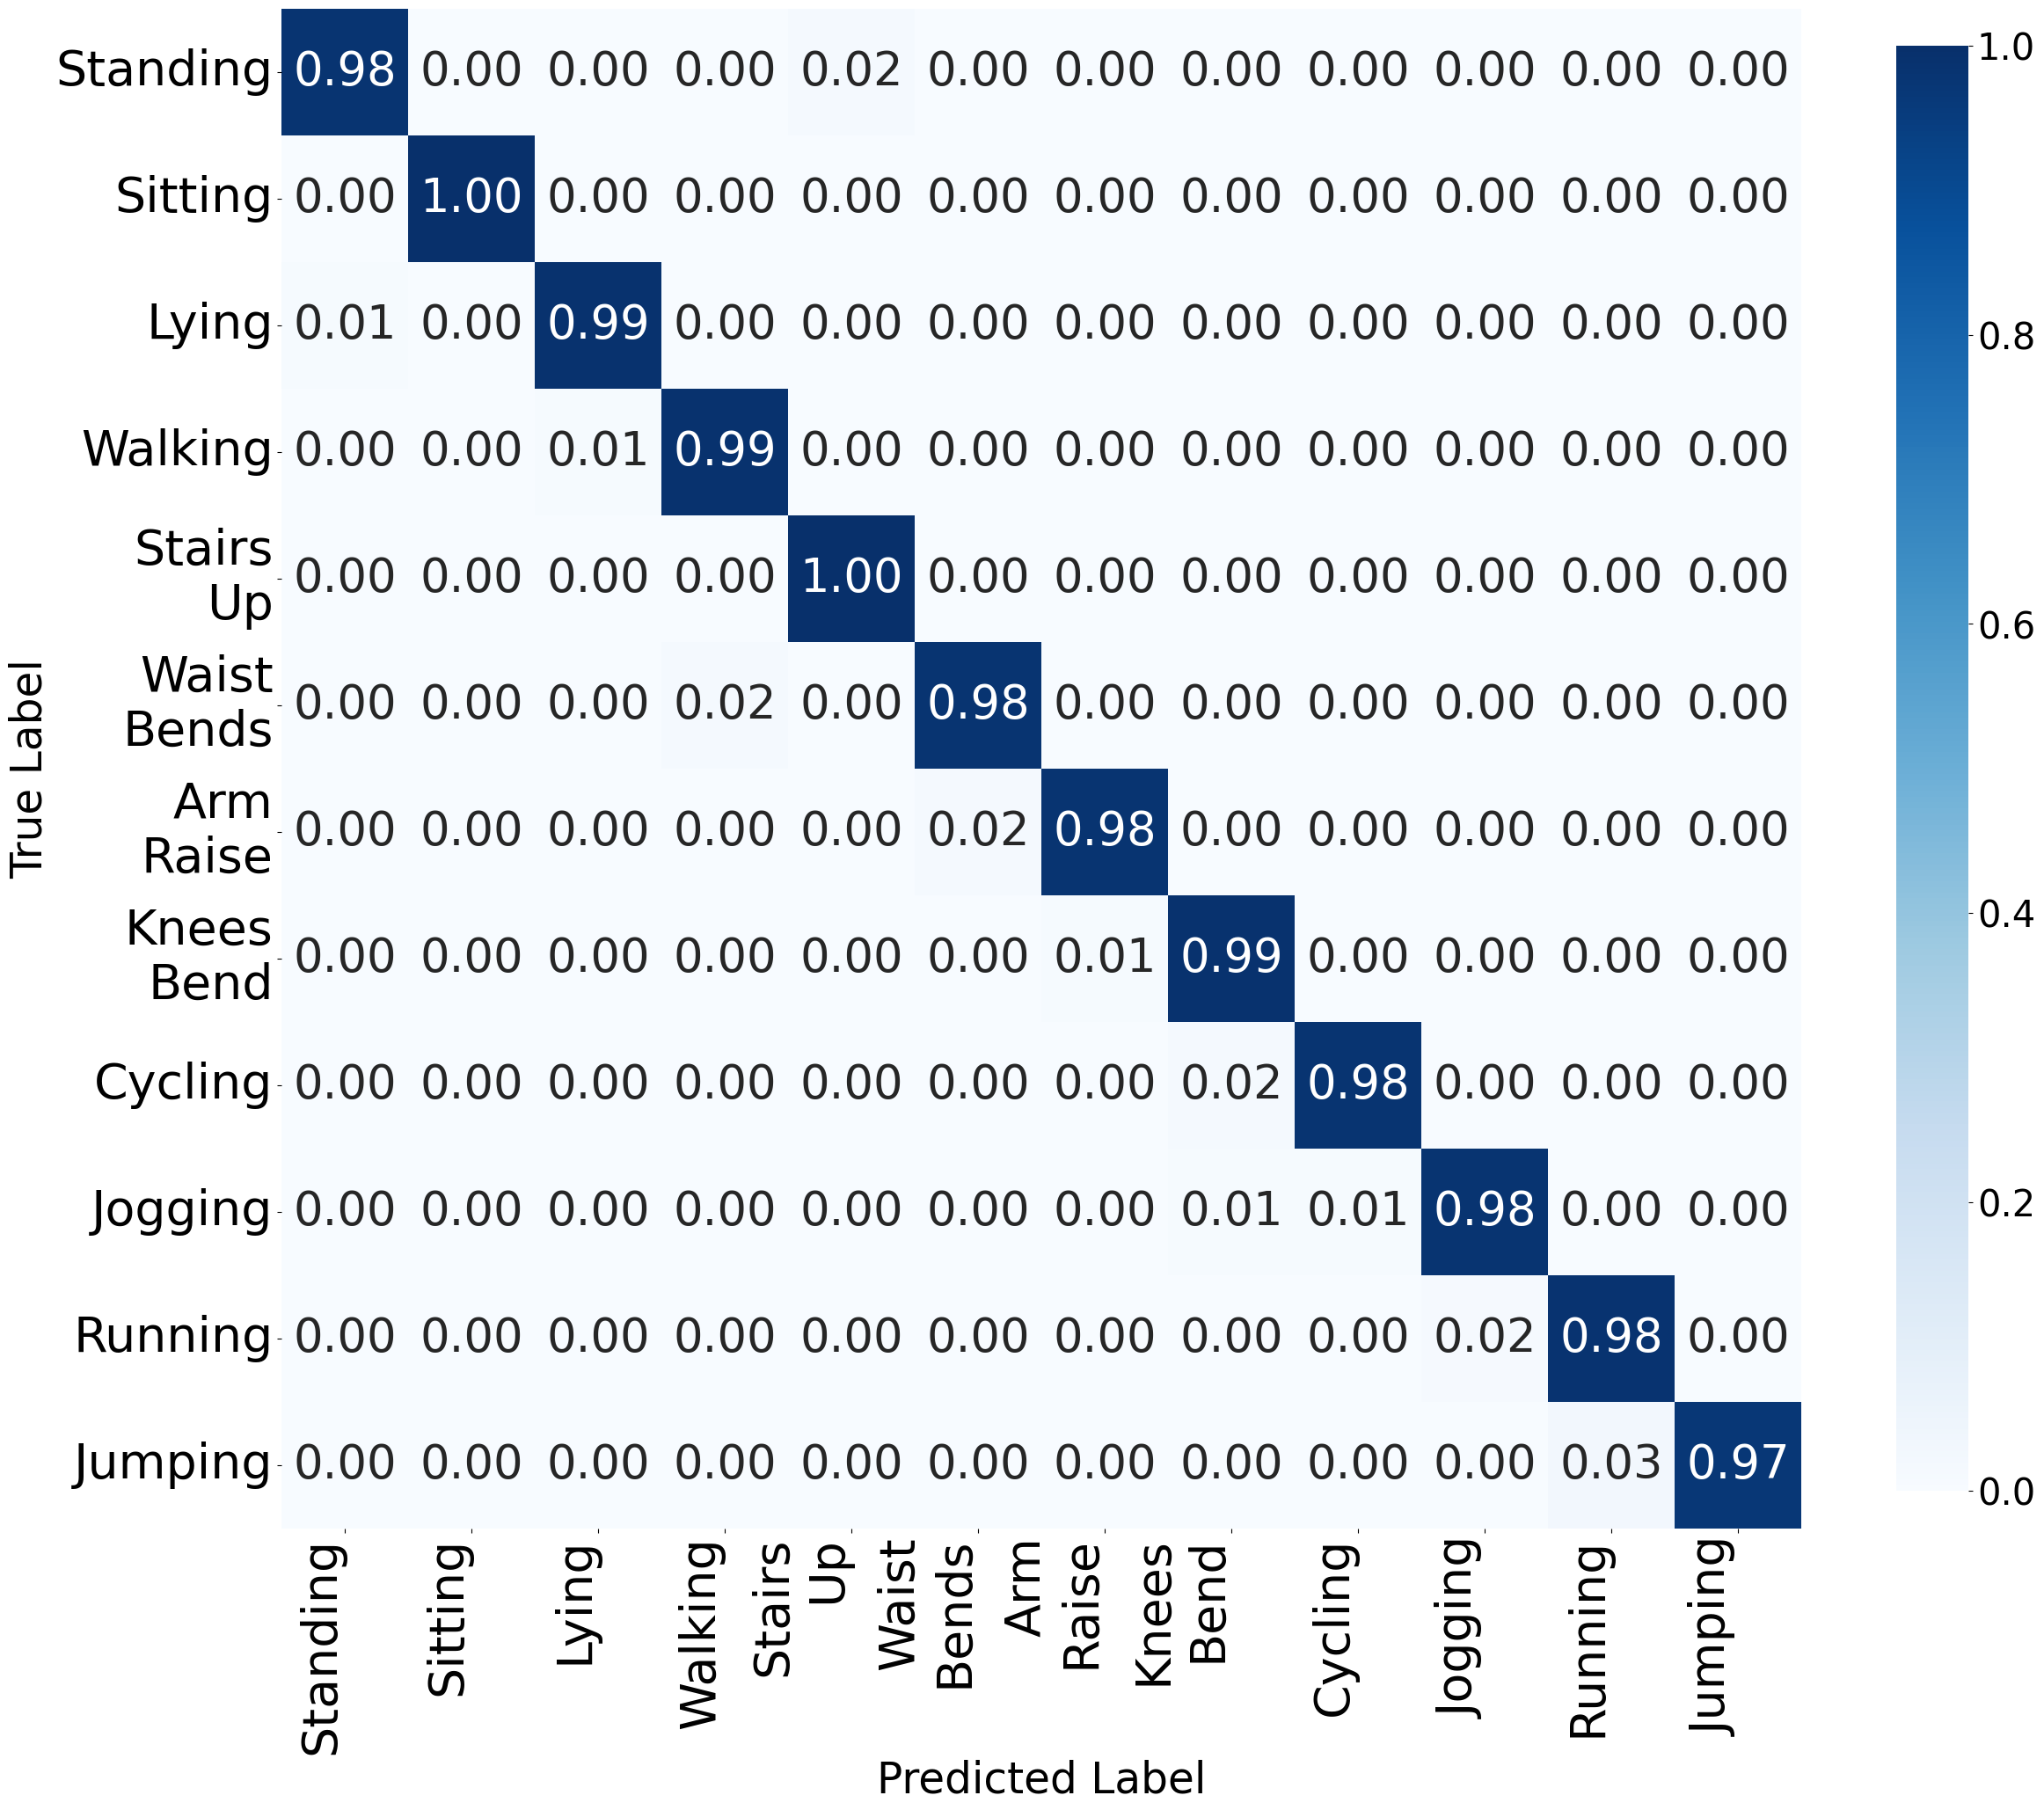


Running t-SNE on 1372 points (Perplexity=30)...


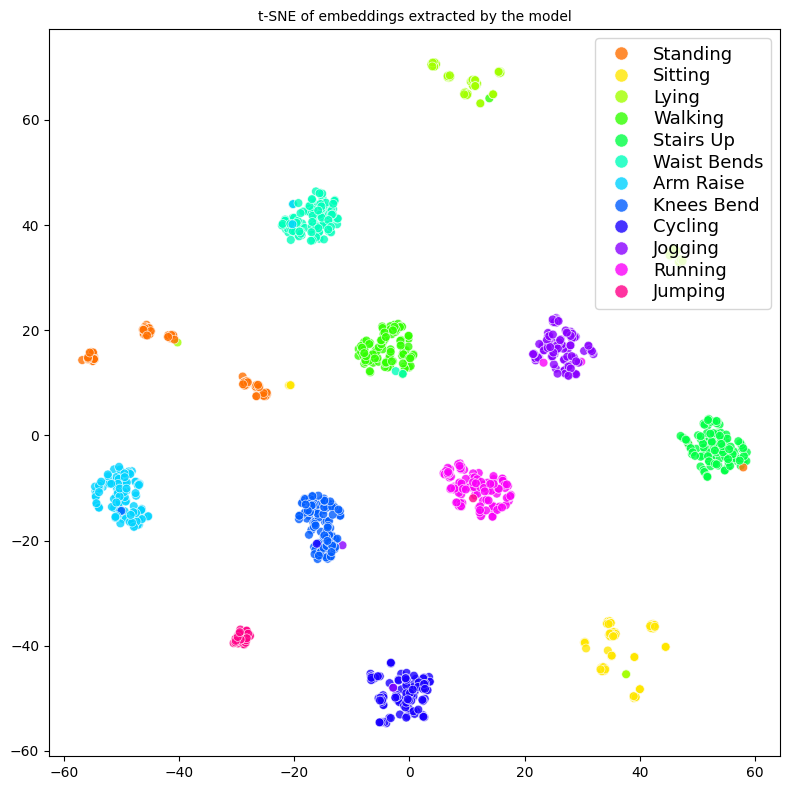


Saved artifacts to: /content/drive/MyDrive/Colab Notebooks/HAR/PADRe/Overall-Results/MHEALTH
 - ckpt: /content/drive/MyDrive/Colab Notebooks/HAR/PADRe/Overall-Results/MHEALTH/best_by_macro_f1.ckpt
 - npy : X_train/X_test/y_train/y_test
 - png : confusion_matrix.png, tsne_embeddings.png


In [1]:
import os, copy, random, time, random, glob
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from fvcore.nn import FlopCountAnalysis

# ──────────────────────────────────────────────────────────────────────────────
# Seed / Device
# ──────────────────────────────────────────────────────────────────────────────
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = DEVICE.type == "cuda"
print(f"Device: {DEVICE} | pin_memory: {USE_GPU}")


# ──────────────────────────────────────────────────────────────────────────────
# Dataset
# ──────────────────────────────────────────────────────────────────────────────
def _load_single_mhealth_log(path: str, feature_cols: list[str]):
    df = pd.read_csv(
        path,
        sep="\t",
        header=None,
        names=feature_cols + ["label"],
    )
    return df

def load_mhealth_dataframe(data_dir: str):
    feature_cols = [
        "acc_chest_x", "acc_chest_y", "acc_chest_z",      # 0,1,2
        "acc_ankle_x", "acc_ankle_y", "acc_ankle_z",      # 5,6,7
        "gyro_ankle_x", "gyro_ankle_y", "gyro_ankle_z",   # 8,9,10
        "acc_arm_x", "acc_arm_y", "acc_arm_z",            # 14,15,16
        "gyro_arm_x", "gyro_arm_y", "gyro_arm_z",         # 17,18,19
    ]  # total 15 channels

    log_files = glob.glob(os.path.join(data_dir, "mHealth_subject*.log"))
    if not log_files:
        raise FileNotFoundError(f"No mHealth_subject*.log files found in {data_dir}")
    print(f"Found {len(log_files)} log files in {data_dir}")

    dfs = []
    for fp in sorted(log_files):
        dfs.append(_load_single_mhealth_log(fp, feature_cols))

    full_df = pd.concat(dfs, ignore_index=True)

    full_df = full_df[full_df["label"] != 0].copy()

    full_df.loc[:, "label"] = full_df["label"] - 1

    return full_df, feature_cols


def create_mhealth_windows(
    df: pd.DataFrame,
    feature_cols: list[str],
    window_size: int,
    step_size: int,
):
    data_arr = df[feature_cols].to_numpy(dtype=np.float32)
    labels_arr = df["label"].to_numpy(dtype=np.int64)
    L = data_arr.shape[0]

    X_list, y_list = [], []
    start = 0
    while start + window_size <= L:
        end = start + window_size
        window_x = data_arr[start:end]
        window_label = labels_arr[end - 1]
        X_list.append(window_x.T)
        y_list.append(int(window_label))
        start += step_size

    if not X_list:
        raise RuntimeError("No windows created. Check window_size / step_size / dataset length.")

    X_np = np.stack(X_list, axis=0).astype(np.float32)
    y_np = np.array(y_list, dtype=np.int64)
    return X_np, y_np


class MHEALTHDataset(Dataset):
    def __init__(self, data_dir: str, window_size: int = 128, step_size: int = 64):
        super().__init__()

        full_df, feature_cols = load_mhealth_dataframe(data_dir)
        X, y = create_mhealth_windows(full_df, feature_cols, window_size, step_size)

        self.X = X
        self.y = y
        self.subjects = np.zeros(len(self.y), dtype=int)

        self.label_names = [
            "Standing still", "Sitting and relaxing", "Lying down",
            "Walking", "Climbing stairs", "Waist bends forward",
            "Frontal elevation of arms", "Knees bending", "Cycling",
            "Jogging", "Running", "Jump front & back",
        ]

        print("Loaded MHEALTH dataset")
        print(f"X shape : {self.X.shape}  (N, C, T)")
        print(f"y shape : {self.y.shape}  (N,)")
        print(f"Classes : {len(self.label_names)}")

    def fit_scaler(self, indices):
        Xtr = self.X[indices]
        N, C, T = Xtr.shape
        X2 = Xtr.transpose(0, 2, 1).reshape(-1, C)

        scaler = StandardScaler()
        scaler.fit(X2)
        self.scaler = scaler
        return scaler

    def apply_scaler(self, scaler=None):
        if scaler is None:
            scaler = self.scaler
        assert scaler is not None, "Scaler is not fitted. Call fit_scaler() first."

        X = self.X
        N, C, T = X.shape
        X2 = X.transpose(0, 2, 1).reshape(-1, C)
        X2 = scaler.transform(X2)
        self.X = X2.reshape(N, T, C).transpose(0, 2, 1).astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx: int):
        return (
            torch.from_numpy(self.X[idx]).float(),
            torch.tensor(self.y[idx]).long(),
            int(self.subjects[idx]),
        )


# ──────────────────────────────────────────────────────────────────────────────
# Compute-Aware Degree Gate
# ──────────────────────────────────────────────────────────────────────────────
class ComputeAwareDegreeGate(nn.Module):
    def __init__(self,
                 channels,
                 max_degree=3,
                 gate_hidden_dim=16,
                 temperature_initial=5.0,
                 temperature_min=0.5
        ):
        super().__init__()
        self.max_degree = max_degree

        self.gate = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(1),
            nn.Linear(channels, gate_hidden_dim),
            nn.GELU(),
            nn.Linear(gate_hidden_dim, max_degree),
        )

        nn.init.zeros_(self.gate[-1].bias)
        if max_degree >= 3:
            self.gate[-1].bias.data[1] = 0.4
        self.register_buffer("temperature", torch.tensor(float(temperature_initial)))
        self.temperature_min = float(temperature_min)

    def set_temperature(self, t):
        self.temperature.fill_(max(float(t), self.temperature_min))

    def forward(self, x):
        logits = self.gate(x)
        soft_probs = F.softmax(logits / self.temperature, dim=-1)

        if self.training:
            hard_idx = logits.argmax(dim=-1)
            hard_oh = F.one_hot(hard_idx, num_classes=self.max_degree).float()
            degree_w = hard_oh - soft_probs.detach() + soft_probs
        else:
            degree_w = F.one_hot(logits.argmax(dim=-1), num_classes=self.max_degree).float()

        return degree_w, logits, soft_probs


# ──────────────────────────────────────────────────────────────────────────────
# PADRe Block
# ──────────────────────────────────────────────────────────────────────────────
class PADReBlock(nn.Module):
    def __init__(self,
                 channels,
                 seq_len,
                 max_degree=3,
                 token_kernel=11,
                 gate_hidden_dim=16,
                 temperature_initial=5.0,
                 temperature_min=0.5,
        ):
        super().__init__()
        self.max_degree = max_degree

        self.degree_gate = ComputeAwareDegreeGate(
            channels,
            max_degree=max_degree,
            gate_hidden_dim=gate_hidden_dim,
            temperature_initial=temperature_initial,
            temperature_min=temperature_min
        )

        self.channel_mixing = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=1) for _ in range(max_degree)
        ])

        self.token_mixing = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=token_kernel,
                      padding=token_kernel // 2, groups=channels)
            for _ in range(max_degree)
        ])

        self.pre_hadamard_channel = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=1) for _ in range(max_degree-1)
        ])

        self.pre_hadamard_token = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=token_kernel,
                      padding=token_kernel // 2, groups=channels)
            for _ in range(max_degree-1)
        ])

        self.norm = nn.LayerNorm(channels)

    def _build_Z(self, x, max_deg):
        Y = [self.token_mixing[i](self.channel_mixing[i](x)) for i in range(max_deg)]
        Z = [Y[0]]
        for i in range(1, max_deg):
            Z_ = self.pre_hadamard_token[i-1](self.pre_hadamard_channel[i-1](Z[-1]))
            Z.append(Z_ * Y[i])
        return Z

    def _hard_forward(self, x, sel):
        B = x.shape[0]
        max_deg = max(1, min(int(sel.max().item()) + 1, self.max_degree))
        Z = self._build_Z(x, max_deg)
        Z_stack = torch.stack(Z, dim=0)
        return Z_stack[sel, torch.arange(B, device=x.device)]

    def forward(self, x, return_gate_info=False):
        dw, logits, sp = self.degree_gate(x)
        sel = dw.argmax(dim=-1)
        out = self._hard_forward(x, sel)

        out = self.norm(out.permute(0, 2, 1)).permute(0, 2, 1)

        if return_gate_info:
            return out, {
                "degree_selection": dw,
                "soft_probs": sp,
                "logits": logits,
                "compute_cost": (sel + 1).float().mean().item()
            }
        return out


# ──────────────────────────────────────────────────────────────────────────────
# Adaptive PADRe Model
# ──────────────────────────────────────────────────────────────────────────────
class PADReHAR(nn.Module):
    def __init__(self,
                 in_channels=9,
                 seq_len=128,
                 num_classes=6,
                 hidden_dim=48,
                 num_layers=3,
                 max_degree=3,
                 gate_hidden_dim=16,
                 dropout=0.2,
                 temperature_initial=5.0,
                 temperature_min=0.5,
        ):
        super().__init__()
        self.num_layers = num_layers
        self.max_degree = max_degree

        self.input_proj = nn.Conv1d(in_channels, hidden_dim, kernel_size=1)

        self.padre_blocks = nn.ModuleList([
            PADReBlock(hidden_dim, seq_len, max_degree=max_degree, token_kernel=11,
                       gate_hidden_dim=gate_hidden_dim,
                       temperature_initial=temperature_initial,
                       temperature_min=temperature_min)
            for _ in range(num_layers)
        ])


        self.ffn = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(hidden_dim, hidden_dim * 2, kernel_size=1),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Conv1d(hidden_dim * 2, hidden_dim, kernel_size=1),
                nn.Dropout(dropout),
            )
            for _ in range(num_layers)
        ])

        self.norms1 = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])
        self.norms2 = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    def set_temperature(self, t):
        for b in self.padre_blocks:
            b.degree_gate.set_temperature(t)

    def _ln(self, norm, x):
        return norm(x.permute(0, 2, 1)).permute(0, 2, 1)

    def forward(self, x, return_gate_info=False, return_details=False):
        x = self.input_proj(x)
        gate_info_list = [] if return_gate_info else None
        total_compute  = 0.0

        for i, block in enumerate(self.padre_blocks):
            res = x

            if return_gate_info:
                x, gi = block(x, return_gate_info=True)
                gate_info_list.append(gi)
                total_compute += gi["compute_cost"]
            else:
                x = block(x)

            x = self._ln(self.norms1[i], x + res)

            res2 = x
            x = self.ffn[i](x)
            x = self._ln(self.norms2[i], x + res2)

        h = self.global_pool(x).squeeze(-1)
        logits = self.classifier(h)

        if return_gate_info:
            return logits, gate_info_list, total_compute
        if return_details:
            return logits, {"h": h}
        return logits


# ──────────────────────────────────────────────────────────────────────────────
# Utils
# ──────────────────────────────────────────────────────────────────────────────
def cosine_temperature(ep, total, tmax=5.0, tmin=0.5):
    r = ep / max(total - 1, 1)
    return tmin + (tmax - tmin) * 0.5 * (1.0 + np.cos(np.pi * r))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def params_in_millions(model: nn.Module) -> float:
    return count_parameters(model) / 1e6

@torch.no_grad()
def compute_flops_m(model: nn.Module, input_shape=(1, 9, 128), device="cpu") -> float:
    model_eval = copy.deepcopy(model).to(device)
    model_eval.eval()
    x = torch.randn(*input_shape, device=device)
    flops = FlopCountAnalysis(model_eval, x).total()
    return flops / 1e6

@torch.no_grad()
def measure_cpu_infer_time_ms_clean(model, input_shape, warmup=50, runs=300):
    m = copy.deepcopy(model).cpu().eval()
    x = torch.randn(*input_shape)

    with torch.inference_mode():
        for _ in range(warmup):
            _ = m(x)
        t0 = time.perf_counter()
        for _ in range(runs):
            _ = m(x)
        t1 = time.perf_counter()

    return (t1 - t0) / runs * 1000.0

@torch.no_grad()
def evaluate_best_model(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb, _ in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        pred = logits.argmax(dim=1).detach().cpu().numpy()
        y_pred.append(pred)
        y_true.append(yb.numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return {
        "acc": acc,
        "macro_precision": prec,
        "macro_recall": rec,
        "macro_f1": f1,
        "y_true": y_true,
        "y_pred": y_pred,
    }

def save_arrays_npy_mhealth(full_dataset: MHEALTHDataset, train_subset, test_subset, out_dir: str):
    os.makedirs(out_dir, exist_ok=True)
    tr_idx = np.asarray(train_subset.indices, dtype=np.int64)
    te_idx = np.asarray(test_subset.indices, dtype=np.int64)
    np.save(os.path.join(out_dir, "X_train.npy"), full_dataset.X[tr_idx])
    np.save(os.path.join(out_dir, "y_train.npy"), full_dataset.y[tr_idx])
    np.save(os.path.join(out_dir, "X_test.npy"),  full_dataset.X[te_idx])
    np.save(os.path.join(out_dir, "y_test.npy"),  full_dataset.y[te_idx])

def save_ckpt(model: nn.Module, best_f1: float, config: dict, out_path: str):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    torch.save(
        {
            "state_dict": model.state_dict(),
            "best_macro_f1": float(best_f1),
            "config": config,
        },
        out_path
    )

ACTIVITY_LABELS = [
    "Standing", "Sitting", "Lying",
    "Walking", "Stairs Up", "Waist Bends",
    "Arm Raise", "Knees Bend", "Cycling",
    "Jogging", "Running", "Jumping",
]
ACTIVITY_LABELS_CM = [name.replace(" ", "\n") for name in ACTIVITY_LABELS]

n_labels = len(ACTIVITY_LABELS)
hsv_colors = sns.color_palette("hsv", n_colors=n_labels)
ACTIVITY_COLOR_MAP = dict(zip(ACTIVITY_LABELS, hsv_colors))


def plot_classification_results(y_true, y_pred, save_path=None):
    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=ACTIVITY_LABELS,
            digits=4,
            zero_division=0,
        )
    )

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(25, 25))
    ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', square=True,
                annot_kws={"size": 38}, cbar_kws={"shrink": 0.7},
                xticklabels=ACTIVITY_LABELS_CM, yticklabels=ACTIVITY_LABELS_CM)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)
    plt.xlabel('Predicted Label', fontsize=35)
    plt.ylabel('True Label', fontsize=35)
    plt.title('')
    plt.xticks(rotation=90, ha='right', fontsize=40)
    plt.yticks(rotation=0, fontsize=40)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600)

    plt.show()
    plt.close()

def _extract_featvec_before_classifier(model, xb, device):
    xb = xb.to(device)
    _, details = model(xb, return_details=True)
    feat_vec = details["h"]
    return feat_vec.detach().cpu()

def plot_tsne_from_cached_features(feats, labels, save_path=None, max_points=2000):
    all_features = feats
    all_labels = labels

    N = all_features.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_features[idx]
    y_sel = all_labels[idx]

    effective_perp = min(30, len(X_sel) - 1)
    effective_perp = max(effective_perp, 5)

    print(f"\nRunning t-SNE on {len(X_sel)} points (Perplexity={effective_perp})...")

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_sel)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40,
    )
    plt.title("t-SNE of embeddings extracted by the model", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300)

    plt.show()
    plt.close()

def visualize_tsne_raw(dataloader, save_path=None, max_points=2000):
    all_raw = []
    all_labels = []

    for xb, yb in dataloader:
        all_raw.append(xb.cpu().numpy())
        all_labels.append(yb.cpu().numpy())

    all_raw = np.concatenate(all_raw, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    N = all_raw.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_raw[idx]
    y_sel = all_labels[idx]

    X_flat = X_sel.reshape(X_sel.shape[0], -1)

    effective_perp = min(30, len(X_flat) - 1)
    effective_perp = max(effective_perp, 5)

    print(f"\nRunning Raw Data t-SNE on {len(X_sel)} points...")

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_flat)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40,
    )
    plt.title("t-SNE of raw data before model processing", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300)

    plt.show()
    plt.close()


@torch.no_grad()
def cache_embeddings_from_loader(model, loader, device, max_batches=None):
    model.eval()
    feats_list = []
    labels_list = []

    for b, (xb, yb, _) in enumerate(loader):
        xb = xb.to(device, non_blocking=True)
        logits, details = model(xb, return_details=True)
        feats_list.append(details["h"].detach().cpu().numpy())
        labels_list.append(yb.numpy())
        if (max_batches is not None) and (b + 1 >= max_batches):
            break

    feats = np.concatenate(feats_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return feats, labels


# ──────────────────────────────────────────────────────────────────────────────
# Train & Eval
# ──────────────────────────────────────────────────────────────────────────────
def train_model(model,
                train_loader,
                test_loader,
                device,
                lr=1e-3,
                weight_decay=1e-4,
                epochs=30,
                seed=42
    ):
    set_seed(seed)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.01)

    best_f1 = -1.0
    best_state = None

    for ep in range(epochs):
        temp = cosine_temperature(ep, epochs, tmax=5.0, tmin=0.5)
        model.set_temperature(temp)

        model.train()
        train_loss_sum = 0.0
        train_n = 0
        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            bs = y.size(0)
            train_loss_sum += loss.item() * bs
            train_n += bs

        scheduler.step()
        train_loss = train_loss_sum / max(train_n, 1)

        model.eval()
        preds_all, labels_all = [], []
        with torch.no_grad():
            for X, y, _ in test_loader:
                X, y = X.to(device), y.to(device)
                preds_all.extend(model(X).argmax(1).cpu().numpy())
                labels_all.extend(y.cpu().numpy())
        test_f1 = f1_score(labels_all, preds_all, average="macro")

        if test_f1 > best_f1:
            best_f1 = test_f1
            best_state = copy.deepcopy(model.state_dict())

        if (ep + 1) % 5 == 0:
            cur_lr = optimizer.param_groups[0]["lr"]
            print(f"Epoch {ep+1:02d}/{epochs} | LR={cur_lr:.4f} | Train Loss={train_loss:.4f} | TestF1={test_f1:.4f} | BestF1={best_f1:.4f} | Temp={temp:.3f}")

    model.load_state_dict(best_state)
    print(f"\nBest Test Macro-F1: {best_f1:.4f}")
    return model, best_f1


# ──────────────────────────────────────────────────────────────────────────────
# Main
# ──────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/HAR/har_orig_datasets/MHEALTHDATASET"
    OUT_DIR = "/content/drive/MyDrive/Colab Notebooks/HAR/PADRe/Overall-Results/MHEALTH"
    SEED = 42
    NUM_WORKERS = 2 if USE_GPU else 0
    PIN_MEMORY = USE_GPU

    BATCH_SIZE = 128
    EPOCHS = 100
    NUM_CLASSES = 12
    HIDDEN_DIM = 48
    NUM_LAYERS = 3
    MAX_DEGREE = 3
    GATE_HIDDEN_DIM = 16
    DROPOUT = 0.3
    LR = 2e-3
    WD = 1e-2

    WINDOW_SIZE = 100
    STEP_SIZE = 50

    os.makedirs(OUT_DIR, exist_ok=True)

    full_dataset = MHEALTHDataset(DATA_PATH, window_size=WINDOW_SIZE, step_size=STEP_SIZE)

    n_total = len(full_dataset)
    n_test = int(0.2 * n_total)
    n_train = n_total - n_test

    g = torch.Generator().manual_seed(SEED)
    train_dataset, test_dataset = random_split(full_dataset, [n_train, n_test], generator=g)

    train_idx = np.asarray(train_dataset.indices, dtype=np.int64)
    scaler = full_dataset.fit_scaler(train_idx)
    full_dataset.apply_scaler(scaler)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    set_seed(SEED)
    model = PADReHAR(in_channels=15,
                     seq_len=WINDOW_SIZE,
                     num_classes=NUM_CLASSES,
                     hidden_dim=HIDDEN_DIM,
                     num_layers=NUM_LAYERS,
                     max_degree=MAX_DEGREE,
                     gate_hidden_dim=GATE_HIDDEN_DIM,
                     dropout=DROPOUT,
                     temperature_initial=5.0,
                     temperature_min=0.5
                     ).to(DEVICE)
    print(f"\nModel params: {count_parameters(model):,}\n")

    model, best_f1 = train_model(model, train_loader, test_loader, DEVICE,
                        lr=LR, weight_decay=WD, epochs=EPOCHS, seed=SEED)

    test_metrics = evaluate_best_model(model, test_loader, DEVICE)

    # Params / FLOPs / CPU infer time
    cpu_ms   = measure_cpu_infer_time_ms_clean(model, input_shape=(1, 15, WINDOW_SIZE))
    params_m = params_in_millions(model)
    flops_m  = compute_flops_m(model, input_shape=(1, 15, WINDOW_SIZE), device="cpu")

    print("\n" + "="*80)
    print("Best Model Summary (selected by Best Test Macro-F1)")
    print("="*80)
    print(f"Accuracy          : {test_metrics['acc']:.4f}")
    print(f"Macro Precision   : {test_metrics['macro_precision']:.4f}")
    print(f"Macro Recall      : {test_metrics['macro_recall']:.4f}")
    print(f"Macro F1          : {test_metrics['macro_f1']:.4f}")
    print(f"Params (M)        : {params_m:.3f}")
    print(f"FLOPs (M)         : {flops_m:.3f}")
    print(f"CPU infer time(ms): {cpu_ms:.3f} (batch=1)")

    # Save ckpt + npy
    config = dict(
        seed=SEED,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        num_classes=NUM_CLASSES,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS,
        max_degree=MAX_DEGREE,
        gate_hidden_dim=GATE_HIDDEN_DIM,
        dropout=DROPOUT,
        lr=LR,
        weight_decay=WD,
        data_path=DATA_PATH,
    )

    ckpt_path = os.path.join(OUT_DIR, "best_by_macro_f1.ckpt")
    save_ckpt(model, best_f1, config, ckpt_path)
    save_arrays_npy_mhealth(full_dataset, train_dataset, test_dataset, OUT_DIR)

    # CM
    cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
    plot_classification_results(
        y_true=test_metrics["y_true"],
        y_pred=test_metrics["y_pred"],
        save_path=cm_path
    )

    # t-SNE (embeddings)
    feats, labels = cache_embeddings_from_loader(model, test_loader, DEVICE)
    tsne_path = os.path.join(OUT_DIR, "tsne_embeddings.png")
    plot_tsne_from_cached_features(feats, labels, save_path=tsne_path, max_points=2000)

    print("\nSaved artifacts to:", OUT_DIR)
    print(" - ckpt:", ckpt_path)
    print(" - npy : X_train/X_test/y_train/y_test")
    print(" - png : confusion_matrix.png, tsne_embeddings.png")

# WISDM

Device: cuda | pin_memory: True
Loaded WISDM dataset (single txt)
  X shape       : (27108, 3, 80)  (N, C, T)
  y shape       : (27108,)  (N,)
  subjects shape: (27108,) (N,)
  num classes   : 6
  unique subjects: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ... (total 36)

Model params: 78,303

Epoch 05/100 | LR=0.0020 | Train Loss=0.1370 | TestF1=0.9611 | BestF1=0.9611 | Temp=4.982
Epoch 10/100 | LR=0.0020 | Train Loss=0.1066 | TestF1=0.9690 | BestF1=0.9712 | Temp=4.909
Epoch 15/100 | LR=0.0019 | Train Loss=0.0908 | TestF1=0.9753 | BestF1=0.9753 | Temp=4.782
Epoch 20/100 | LR=0.0018 | Train Loss=0.0834 | TestF1=0.9696 | BestF1=0.9757 | Temp=4.603
Epoch 25/100 | LR=0.0017 | Train Loss=0.0828 | TestF1=0.9734 | BestF1=0.9774 | Temp=4.378
Epoch 30/100 | LR=0.0016 | Train Loss=0.0717 | TestF1=0.9735 | BestF1=0.9774 | Temp=4.113
Epoch 35/100 | LR=0.0015 | Train Loss=0.0722 | TestF1=0.9751 | BestF1=0.9796

padre_blocks.0.channel_mixing.2, padre_blocks.0.pre_hadamard_channel.1, padre_blocks.0.pre_hadamard_token.1, padre_blocks.0.token_mixing.2, padre_blocks.1.channel_mixing.2, padre_blocks.1.pre_hadamard_channel.1, padre_blocks.1.pre_hadamard_token.1, padre_blocks.1.token_mixing.2, padre_blocks.2.channel_mixing.2, padre_blocks.2.pre_hadamard_channel.1, padre_blocks.2.pre_hadamard_token.1, padre_blocks.2.token_mixing.2



Best Model Summary (selected by Best Test Macro-F1)
Accuracy          : 0.9884
Macro Precision   : 0.9815
Macro Recall      : 0.9815
Macro F1          : 0.9814
Params (M)        : 0.078
FLOPs (M)         : 4.440
CPU infer time(ms): 4.366 (batch=1)

Classification Report
              precision    recall  f1-score   support

     Walking     0.9976    0.9966    0.9971      2081
     Jogging     0.9970    0.9970    0.9970      1659
     Sitting     0.9969    0.9817    0.9892       328
    Standing     0.9881    0.9920    0.9901       251
    Upstairs     0.9645    0.9629    0.9637       620
  Downstairs     0.9448    0.9585    0.9516       482

    accuracy                         0.9884      5421
   macro avg     0.9815    0.9815    0.9814      5421
weighted avg     0.9884    0.9884    0.9884      5421



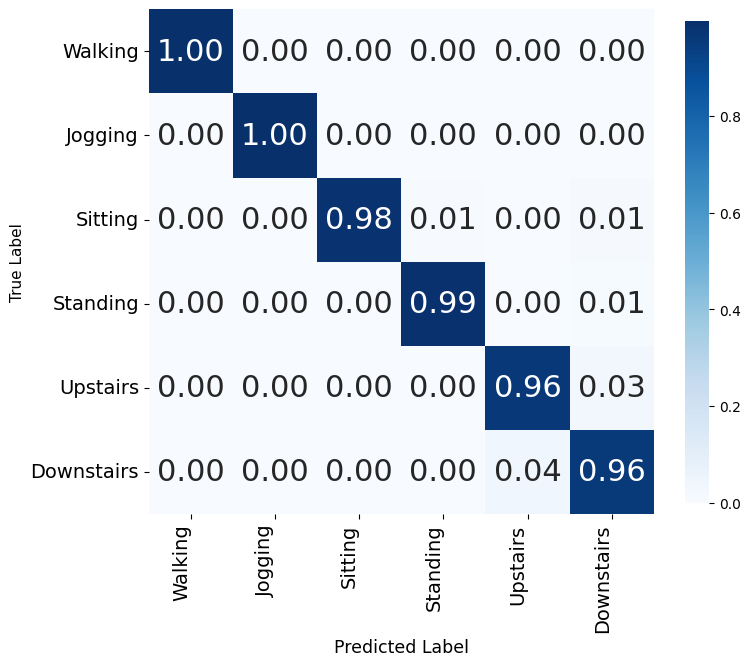


Running t-SNE on 2000 points (Perplexity=30)...


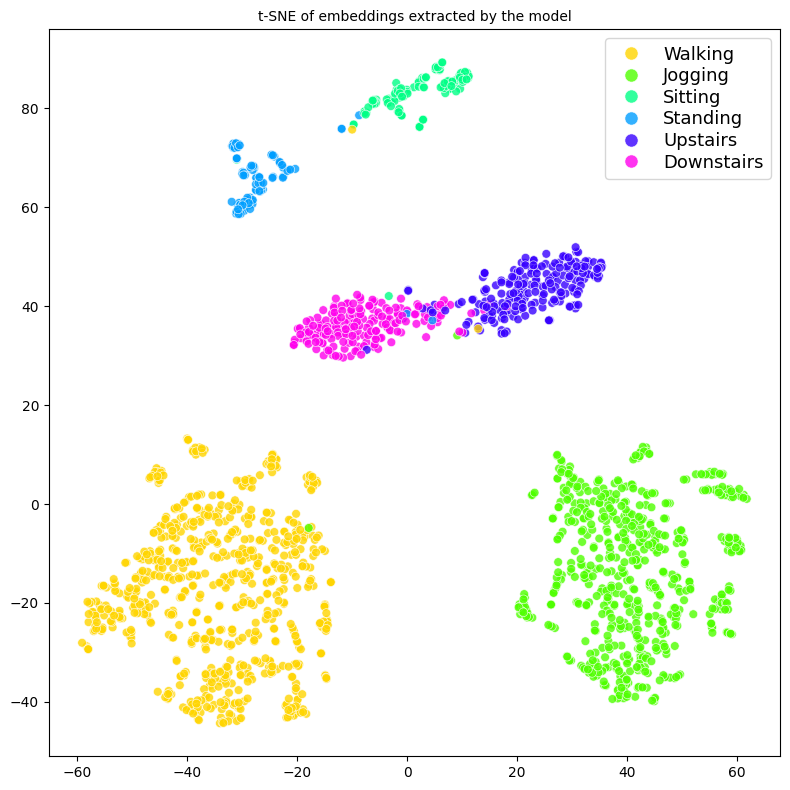


Saved artifacts to: /content/drive/MyDrive/Colab Notebooks/HAR/PADRe/Overall-Results/WISDM
 - ckpt: /content/drive/MyDrive/Colab Notebooks/HAR/PADRe/Overall-Results/WISDM/best_by_macro_f1.ckpt
 - npy : X_train/X_test/y_train/y_test
 - png : confusion_matrix.png, tsne_embeddings.png


In [2]:
import os, copy, random, time
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from fvcore.nn import FlopCountAnalysis

# ──────────────────────────────────────────────────────────────────────────────
# Seed / Device
# ──────────────────────────────────────────────────────────────────────────────
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = DEVICE.type == "cuda"
print(f"Device: {DEVICE} | pin_memory: {USE_GPU}")


# ──────────────────────────────────────────────────────────────────────────────
# Dataset
# ──────────────────────────────────────────────────────────────────────────────
class WISDMDataset(Dataset):
    def __init__(self, file_path: str, window_size: int = 80, step_size: int = 40):
        super().__init__()
        self.file_path = file_path
        self.window_size = window_size
        self.step_size = step_size

        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"WISDM txt file not found: {file_path}")

        df = self._load_file(file_path)
        self.X, self.y, self.subjects = self._create_windows(df)
        self.unique_subjects = sorted(np.unique(self.subjects))

        self.n_classes = int(len(np.unique(self.y)))

        print("=" * 80)
        print("Loaded WISDM dataset (single txt)")
        print(f"  X shape       : {self.X.shape}  (N, C, T)")
        print(f"  y shape       : {self.y.shape}  (N,)")
        print(f"  subjects shape: {self.subjects.shape} (N,)")
        print(f"  num classes   : {self.n_classes}")
        print(f"  unique subjects: {self.unique_subjects[:10]} ... (total {len(self.unique_subjects)})")
        print("=" * 80)

    def _load_file(self, file_path: str) -> pd.DataFrame:
        WISDM_LABEL_MAP = {
            "walking": 0,
            "jogging": 1,
            "sitting": 2,
            "standing": 3,
            "upstairs": 4,
            "downstairs": 5,
        }

        with open(file_path, "r") as f:
            lines = f.readlines()

        rows = []
        for line in lines:
            line = line.strip()
            if not line:
                continue
            line = line.replace(";", "")
            parts = line.split(",")

            if len(parts) != 6:
                continue

            subj, act, ts, x, y, z = parts
            if x.strip() == "" or y.strip() == "" or z.strip() == "":
                continue

            act_norm = act.strip().lower()
            if act_norm not in WISDM_LABEL_MAP:
                continue

            rows.append([subj, act_norm, ts, x, y, z])

        if not rows:
            raise ValueError(f"No valid rows parsed from file: {file_path}")

        df = pd.DataFrame(rows, columns=["subject", "activity", "timestamp", "x", "y", "z"])
        df = df.replace(["", "NaN", "nan"], np.nan).dropna(subset=["subject", "x", "y", "z"])

        df["subject"] = pd.to_numeric(df["subject"], errors="coerce")
        df["x"] = pd.to_numeric(df["x"], errors="coerce")
        df["y"] = pd.to_numeric(df["y"], errors="coerce")
        df["z"] = pd.to_numeric(df["z"], errors="coerce")
        df = df.dropna(subset=["subject", "x", "y", "z"])
        if df.empty:
            raise ValueError("After cleaning, WISDM DataFrame is empty. Check file format.")

        df["subject"] = df["subject"].astype(int)
        df["activity_id"] = df["activity"].map(WISDM_LABEL_MAP).astype(int)

        return df

    def _create_windows(self, df: pd.DataFrame):
        X_list, y_list, s_list = [], [], []

        for subj_id in sorted(df["subject"].unique()):
            df_sub = df[df["subject"] == subj_id]
            data = df_sub[["x", "y", "z"]].to_numpy(dtype=np.float32)
            labels = df_sub["activity_id"].to_numpy(dtype=np.int64)
            L = len(df_sub)

            start = 0
            while start + self.window_size <= L:
                end = start + self.window_size
                window_x = data[start:end]
                window_y = labels[end - 1]

                X_list.append(window_x.T)
                y_list.append(window_y)
                s_list.append(subj_id)

                start += self.step_size

        if len(X_list) == 0:
            raise ValueError("[WISDMDataset] No windows created. Try smaller window_size or check data.")

        X = np.stack(X_list, axis=0).astype(np.float32)
        y = np.array(y_list, dtype=np.int64)
        s = np.array(s_list, dtype=np.int64)
        return X, y, s

    def fit_scaler(self, indices):
        Xtr = self.X[indices]  # (N,C,T)
        N, C, T = Xtr.shape
        X2 = np.transpose(Xtr, (0, 2, 1)).reshape(-1, C)  # (N*T, C)
        scaler = StandardScaler()
        scaler.fit(X2)
        self.scaler = scaler
        return scaler

    def apply_scaler(self, scaler=None):
        if scaler is None:
            scaler = getattr(self, "scaler", None)
        assert scaler is not None, "Scaler is not fitted. Call fit_scaler() first."

        X = self.X
        N, C, T = X.shape
        X2 = np.transpose(X, (0, 2, 1)).reshape(-1, C)
        X2 = scaler.transform(X2)
        self.X = X2.reshape(N, T, C).transpose(0, 2, 1).astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx: int):
        return (
            torch.FloatTensor(self.X[idx]),
            torch.LongTensor([self.y[idx]])[0],
            int(self.subjects[idx]),
        )


# ──────────────────────────────────────────────────────────────────────────────
# Compute-Aware Degree Gate
# ──────────────────────────────────────────────────────────────────────────────
class ComputeAwareDegreeGate(nn.Module):
    def __init__(self,
                 channels,
                 max_degree=3,
                 gate_hidden_dim=16,
                 temperature_initial=5.0,
                 temperature_min=0.5
        ):
        super().__init__()
        self.max_degree = max_degree

        self.gate = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(1),
            nn.Linear(channels, gate_hidden_dim),
            nn.GELU(),
            nn.Linear(gate_hidden_dim, max_degree),
        )

        nn.init.zeros_(self.gate[-1].bias)
        if max_degree >= 3:
            self.gate[-1].bias.data[1] = 0.4
        self.register_buffer("temperature", torch.tensor(float(temperature_initial)))
        self.temperature_min = float(temperature_min)

    def set_temperature(self, t):
        self.temperature.fill_(max(float(t), self.temperature_min))

    def forward(self, x):
        logits = self.gate(x)
        soft_probs = F.softmax(logits / self.temperature, dim=-1)

        if self.training:
            hard_idx = logits.argmax(dim=-1)
            hard_oh = F.one_hot(hard_idx, num_classes=self.max_degree).float()
            degree_w = hard_oh - soft_probs.detach() + soft_probs
        else:
            degree_w = F.one_hot(logits.argmax(dim=-1), num_classes=self.max_degree).float()

        return degree_w, logits, soft_probs


# ──────────────────────────────────────────────────────────────────────────────
# PADRe Block
# ──────────────────────────────────────────────────────────────────────────────
class PADReBlock(nn.Module):
    def __init__(self,
                 channels,
                 seq_len,
                 max_degree=3,
                 token_kernel=11,
                 gate_hidden_dim=16,
                 temperature_initial=5.0,
                 temperature_min=0.5,
        ):
        super().__init__()
        self.max_degree = max_degree

        self.degree_gate = ComputeAwareDegreeGate(
            channels,
            max_degree=max_degree,
            gate_hidden_dim=gate_hidden_dim,
            temperature_initial=temperature_initial,
            temperature_min=temperature_min
        )

        self.channel_mixing = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=1) for _ in range(max_degree)
        ])

        self.token_mixing = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=token_kernel,
                      padding=token_kernel // 2, groups=channels)
            for _ in range(max_degree)
        ])

        self.pre_hadamard_channel = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=1) for _ in range(max_degree-1)
        ])

        self.pre_hadamard_token = nn.ModuleList([
            nn.Conv1d(channels, channels, kernel_size=token_kernel,
                      padding=token_kernel // 2, groups=channels)
            for _ in range(max_degree-1)
        ])

        self.norm = nn.LayerNorm(channels)

    def _build_Z(self, x, max_deg):
        Y = [self.token_mixing[i](self.channel_mixing[i](x)) for i in range(max_deg)]
        Z = [Y[0]]
        for i in range(1, max_deg):
            Z_ = self.pre_hadamard_token[i-1](self.pre_hadamard_channel[i-1](Z[-1]))
            Z.append(Z_ * Y[i])
        return Z

    def _hard_forward(self, x, sel):
        B = x.shape[0]
        max_deg = max(1, min(int(sel.max().item()) + 1, self.max_degree))
        Z = self._build_Z(x, max_deg)
        Z_stack = torch.stack(Z, dim=0)
        return Z_stack[sel, torch.arange(B, device=x.device)]

    def forward(self, x, return_gate_info=False):
        dw, logits, sp = self.degree_gate(x)
        sel = dw.argmax(dim=-1)
        out = self._hard_forward(x, sel)

        out = self.norm(out.permute(0, 2, 1)).permute(0, 2, 1)

        if return_gate_info:
            return out, {
                "degree_selection": dw,
                "soft_probs": sp,
                "logits": logits,
                "compute_cost": (sel + 1).float().mean().item()
            }
        return out


# ──────────────────────────────────────────────────────────────────────────────
# Adaptive PADRe Model
# ──────────────────────────────────────────────────────────────────────────────
class PADReHAR(nn.Module):
    def __init__(self,
                 in_channels=9,
                 seq_len=128,
                 num_classes=6,
                 hidden_dim=48,
                 num_layers=3,
                 max_degree=3,
                 gate_hidden_dim=16,
                 dropout=0.2,
                 temperature_initial=5.0,
                 temperature_min=0.5,
        ):
        super().__init__()
        self.num_layers = num_layers
        self.max_degree = max_degree

        self.input_proj = nn.Conv1d(in_channels, hidden_dim, kernel_size=1)

        self.padre_blocks = nn.ModuleList([
            PADReBlock(hidden_dim, seq_len, max_degree=max_degree, token_kernel=11,
                       gate_hidden_dim=gate_hidden_dim,
                       temperature_initial=temperature_initial,
                       temperature_min=temperature_min)
            for _ in range(num_layers)
        ])


        self.ffn = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(hidden_dim, hidden_dim * 2, kernel_size=1),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Conv1d(hidden_dim * 2, hidden_dim, kernel_size=1),
                nn.Dropout(dropout),
            )
            for _ in range(num_layers)
        ])

        self.norms1 = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])
        self.norms2 = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    def set_temperature(self, t):
        for b in self.padre_blocks:
            b.degree_gate.set_temperature(t)

    def _ln(self, norm, x):
        return norm(x.permute(0, 2, 1)).permute(0, 2, 1)

    def forward(self, x, return_gate_info=False, return_details=False):
        x = self.input_proj(x)
        gate_info_list = [] if return_gate_info else None
        total_compute  = 0.0

        for i, block in enumerate(self.padre_blocks):
            res = x

            if return_gate_info:
                x, gi = block(x, return_gate_info=True)
                gate_info_list.append(gi)
                total_compute += gi["compute_cost"]
            else:
                x = block(x)

            x = self._ln(self.norms1[i], x + res)

            res2 = x
            x = self.ffn[i](x)
            x = self._ln(self.norms2[i], x + res2)

        h = self.global_pool(x).squeeze(-1)
        logits = self.classifier(h)

        if return_gate_info:
            return logits, gate_info_list, total_compute
        if return_details:
            return logits, {"h": h}
        return logits


# ──────────────────────────────────────────────────────────────────────────────
# Utils
# ──────────────────────────────────────────────────────────────────────────────
def cosine_temperature(ep, total, tmax=5.0, tmin=0.5):
    r = ep / max(total - 1, 1)
    return tmin + (tmax - tmin) * 0.5 * (1.0 + np.cos(np.pi * r))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def params_in_millions(model: nn.Module) -> float:
    return count_parameters(model) / 1e6

@torch.no_grad()
def compute_flops_m(model: nn.Module, input_shape=(1, 9, 128), device="cpu") -> float:
    model_eval = copy.deepcopy(model).to(device)
    model_eval.eval()
    x = torch.randn(*input_shape, device=device)
    flops = FlopCountAnalysis(model_eval, x).total()
    return flops / 1e6

@torch.no_grad()
def measure_cpu_infer_time_ms_clean(model, input_shape, warmup=50, runs=300):
    m = copy.deepcopy(model).cpu().eval()
    x = torch.randn(*input_shape)

    with torch.inference_mode():
        for _ in range(warmup):
            _ = m(x)
        t0 = time.perf_counter()
        for _ in range(runs):
            _ = m(x)
        t1 = time.perf_counter()

    return (t1 - t0) / runs * 1000.0

@torch.no_grad()
def evaluate_best_model(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb, _ in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        pred = logits.argmax(dim=1).detach().cpu().numpy()
        y_pred.append(pred)
        y_true.append(yb.numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return {
        "acc": acc,
        "macro_precision": prec,
        "macro_recall": rec,
        "macro_f1": f1,
        "y_true": y_true,
        "y_pred": y_pred,
    }

def save_arrays_npy_wisdm(full_dataset: WISDMDataset, train_subset, test_subset, out_dir: str):
    os.makedirs(out_dir, exist_ok=True)

    tr_idx = np.asarray(train_subset.indices, dtype=np.int64)
    te_idx = np.asarray(test_subset.indices, dtype=np.int64)

    np.save(os.path.join(out_dir, "X_train.npy"), full_dataset.X[tr_idx])   # (N,C,T)
    np.save(os.path.join(out_dir, "y_train.npy"), full_dataset.y[tr_idx])
    np.save(os.path.join(out_dir, "subj_train.npy"), full_dataset.subjects[tr_idx])

    np.save(os.path.join(out_dir, "X_test.npy"),  full_dataset.X[te_idx])
    np.save(os.path.join(out_dir, "y_test.npy"),  full_dataset.y[te_idx])
    np.save(os.path.join(out_dir, "subj_test.npy"), full_dataset.subjects[te_idx])

def save_ckpt(model: nn.Module, best_f1: float, config: dict, out_path: str):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    torch.save(
        {
            "state_dict": model.state_dict(),
            "best_macro_f1": float(best_f1),
            "config": config,
        },
        out_path
    )

ACTIVITY_LABELS_CM = [
    "Walking",
    "Jogging",
    "Sitting",
    "Standing",
    "Upstairs",
    "Downstairs",
]

ACTIVITY_LABELS = [
    "Walking",
    "Jogging",
    "Sitting",
    "Standing",
    "Upstairs",
    "Downstairs",
]

n_labels = len(ACTIVITY_LABELS)
hsv_colors = sns.color_palette("hsv", n_colors=n_labels)
ACTIVITY_COLOR_MAP = dict(zip(ACTIVITY_LABELS, hsv_colors))


def plot_classification_results(y_true, y_pred, save_path=None):
    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=ACTIVITY_LABELS,
            digits=4,
            zero_division=0,
        )
    )

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', square=True,
                annot_kws={"size": 22}, cbar_kws={"shrink": 0.7},
                xticklabels=ACTIVITY_LABELS_CM, yticklabels=ACTIVITY_LABELS_CM)
    plt.xlabel('Predicted Label', fontsize=12.5)
    plt.ylabel('True Label', fontsize=11)
    plt.title('')
    plt.xticks(rotation=90, ha='right', fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600)

    plt.show()
    plt.close()

def _extract_featvec_before_classifier(model, xb, device):
    xb = xb.to(device)
    _, details = model(xb, return_details=True)
    feat_vec = details["h"]
    return feat_vec.detach().cpu()

def plot_tsne_from_cached_features(feats, labels, save_path=None, max_points=2000):
    all_features = feats
    all_labels = labels

    N = all_features.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_features[idx]
    y_sel = all_labels[idx]

    effective_perp = min(30, len(X_sel) - 1)
    effective_perp = max(effective_perp, 5)

    print(f"\nRunning t-SNE on {len(X_sel)} points (Perplexity={effective_perp})...")

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=30,
        max_iter=3000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_sel)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40,
    )
    plt.title("t-SNE of embeddings extracted by the model", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300)

    plt.show()
    plt.close()

def visualize_tsne_raw(dataloader, save_path=None, max_points=2000):
    all_raw = []
    all_labels = []

    for xb, yb, _ in dataloader:
        all_raw.append(xb.cpu().numpy())
        all_labels.append(yb.cpu().numpy())

    all_raw = np.concatenate(all_raw, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    N = all_raw.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_raw[idx]
    y_sel = all_labels[idx]

    X_flat = X_sel.reshape(X_sel.shape[0], -1)

    effective_perp = min(30, len(X_flat) - 1)
    effective_perp = max(effective_perp, 5)

    print(f"\nRunning Raw Data t-SNE on {len(X_sel)} points...")

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_flat)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40,
    )
    plt.title("t-SNE of raw data before model processing", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300)

    plt.show()
    plt.close()

@torch.no_grad()
def cache_embeddings_from_loader(model, loader, device, max_batches=None):
    model.eval()
    feats_list = []
    labels_list = []

    for b, (xb, yb, _) in enumerate(loader):
        xb = xb.to(device, non_blocking=True)
        logits, details = model(xb, return_details=True)
        feats_list.append(details["h"].detach().cpu().numpy())
        labels_list.append(yb.numpy())

        if (max_batches is not None) and (b + 1 >= max_batches):
            break

    feats = np.concatenate(feats_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return feats, labels


# ──────────────────────────────────────────────────────────────────────────────
# Train & Eval
# ──────────────────────────────────────────────────────────────────────────────
def train_model(model,
                train_loader,
                test_loader,
                device,
                lr=1e-3,
                weight_decay=1e-4,
                epochs=30,
                seed=42
    ):
    set_seed(seed)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.01)

    best_f1 = -1.0
    best_state = None

    for ep in range(epochs):
        temp = cosine_temperature(ep, epochs, tmax=5.0, tmin=0.5)
        model.set_temperature(temp)

        model.train()
        train_loss_sum = 0.0
        train_n = 0
        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            bs = y.size(0)
            train_loss_sum += loss.item() * bs
            train_n += bs

        scheduler.step()
        train_loss = train_loss_sum / max(train_n, 1)

        model.eval()
        preds_all, labels_all = [], []
        with torch.no_grad():
            for X, y, _ in test_loader:
                X, y = X.to(device), y.to(device)
                preds_all.extend(model(X).argmax(1).cpu().numpy())
                labels_all.extend(y.cpu().numpy())
        test_f1 = f1_score(labels_all, preds_all, average="macro")

        if test_f1 > best_f1:
            best_f1 = test_f1
            best_state = copy.deepcopy(model.state_dict())

        if (ep + 1) % 5 == 0:
            cur_lr = optimizer.param_groups[0]["lr"]
            print(f"Epoch {ep+1:02d}/{epochs} | LR={cur_lr:.4f} | Train Loss={train_loss:.4f} | TestF1={test_f1:.4f} | BestF1={best_f1:.4f} | Temp={temp:.3f}")

    model.load_state_dict(best_state)
    print(f"\nBest Test Macro-F1: {best_f1:.4f}")
    return model, best_f1


# ──────────────────────────────────────────────────────────────────────────────
# Main
# ──────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/HAR/har_orig_datasets/WISDM_ar_v1.1_raw.txt"
    OUT_DIR = "/content/drive/MyDrive/Colab Notebooks/HAR/PADRe/Overall-Results/WISDM"
    SEED = 42
    NUM_WORKERS = 2 if USE_GPU else 0
    PIN_MEMORY = USE_GPU

    BATCH_SIZE = 128
    EPOCHS = 100
    NUM_CLASSES = 6
    HIDDEN_DIM = 48
    NUM_LAYERS = 3
    MAX_DEGREE = 3
    GATE_HIDDEN_DIM = 16
    DROPOUT = 0.3
    LR = 2e-3
    WD = 1e-2

    WINDOW_SIZE=80
    STEP_SIZE=40

    os.makedirs(OUT_DIR, exist_ok=True)

    full_dataset = WISDMDataset(DATA_PATH, window_size=WINDOW_SIZE, step_size=STEP_SIZE)

    n_total = len(full_dataset)
    n_test = int(0.2 * n_total)
    n_train = n_total - n_test

    g = torch.Generator().manual_seed(SEED)
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [n_train, n_test], generator=g)

    train_idx = np.array(train_dataset.indices, dtype=np.int64)
    scaler = full_dataset.fit_scaler(train_idx)
    full_dataset.apply_scaler(scaler)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    set_seed(SEED)
    model = PADReHAR(in_channels=3,
                     seq_len=WINDOW_SIZE,
                     num_classes=NUM_CLASSES,
                     hidden_dim=HIDDEN_DIM,
                     num_layers=NUM_LAYERS,
                     max_degree=MAX_DEGREE,
                     gate_hidden_dim=GATE_HIDDEN_DIM,
                     dropout=DROPOUT,
                     temperature_initial=5.0,
                     temperature_min=0.5
                     ).to(DEVICE)
    print(f"\nModel params: {count_parameters(model):,}\n")

    model, best_f1 = train_model(model, train_loader, test_loader, DEVICE,
                        lr=LR, weight_decay=WD, epochs=EPOCHS, seed=SEED)

    test_metrics = evaluate_best_model(model, test_loader, DEVICE)

    # Params / FLOPs / CPU infer time
    cpu_ms   = measure_cpu_infer_time_ms_clean(model, input_shape=(1, 3, WINDOW_SIZE))
    params_m = params_in_millions(model)
    flops_m  = compute_flops_m(model, input_shape=(1, 3, WINDOW_SIZE), device="cpu")

    print("\n" + "="*80)
    print("Best Model Summary (selected by Best Test Macro-F1)")
    print("="*80)
    print(f"Accuracy          : {test_metrics['acc']:.4f}")
    print(f"Macro Precision   : {test_metrics['macro_precision']:.4f}")
    print(f"Macro Recall      : {test_metrics['macro_recall']:.4f}")
    print(f"Macro F1          : {test_metrics['macro_f1']:.4f}")
    print(f"Params (M)        : {params_m:.3f}")
    print(f"FLOPs (M)         : {flops_m:.3f}")
    print(f"CPU infer time(ms): {cpu_ms:.3f} (batch=1)")

    # Save ckpt + npy
    config = dict(
        seed=SEED,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        num_classes=NUM_CLASSES,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS,
        max_degree=MAX_DEGREE,
        gate_hidden_dim=GATE_HIDDEN_DIM,
        dropout=DROPOUT,
        lr=LR,
        weight_decay=WD,
        data_path=DATA_PATH,
    )

    ckpt_path = os.path.join(OUT_DIR, "best_by_macro_f1.ckpt")
    save_ckpt(model, best_f1, config, ckpt_path)
    save_arrays_npy_wisdm(full_dataset, train_dataset, test_dataset, OUT_DIR)

    # CM
    cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
    plot_classification_results(
        y_true=test_metrics["y_true"],
        y_pred=test_metrics["y_pred"],
        save_path=cm_path
    )

    # t-SNE (embeddings)
    feats, labels = cache_embeddings_from_loader(model, test_loader, DEVICE)
    tsne_path = os.path.join(OUT_DIR, "tsne_embeddings.png")
    plot_tsne_from_cached_features(feats, labels, save_path=tsne_path, max_points=2000)

    print("\nSaved artifacts to:", OUT_DIR)
    print(" - ckpt:", ckpt_path)
    print(" - npy : X_train/X_test/y_train/y_test")
    print(" - png : confusion_matrix.png, tsne_embeddings.png")